In [19]:
# IOL CALCULATION FOR PRE-DMEK PATIENTS - SETUP AND DATA LOADING
# ================================================================
# PURPOSE: Set up the analysis environment and load patient data
# This notebook optimizes IOL power calculations for Fuchs' dystrophy patients
# undergoing combined phacoemulsification and DMEK surgery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Constants for clinical accuracy thresholds (diopters)
THRESHOLDS = [0.25, 0.50, 0.75, 1.00]
TEST_SIZE = 0.25      # 25% holdout for final testing
N_FOLDS = 5           # 5-fold cross-validation

# MULTI-SEED CONFIGURATION FOR ROBUST VALIDATION
#SEEDS = [42]  # Quick test with single seed
#SEEDS = [42, 123]  # Medium test with 2 seeds
SEEDS = [42, 123, 456, 789, 2025]  # Multiple seeds for statistical robustness
print("=" * 70)
print("🔧 MULTI-SEED CONFIGURATION")
print("=" * 70)
print(f"Seeds for validation: {SEEDS}")
print("This ensures results are not dependent on random split")
print("Each seed creates different train/test splits for robust assessment")

# Storage for multi-seed results
multi_seed_results = {

    'parameter': {},
    'multiplicative': {},
    'additive': {},
    'combined': {},
    'fixed_combined': {}
}

print("=" * 70)
print("IOL CALCULATION FOR PRE-DMEK PATIENTS")
print("=" * 70)

print("\n📊 WHAT WE'RE DOING:")
print("-" * 50)
print("• Loading data from Fuchs' dystrophy patients")
print("• These patients had combined cataract + DMEK surgery")
print("• Goal: Improve IOL power calculation accuracy")
print("• Challenge: Edematous corneas distort standard formulas")
print(f"• NEW: Using {len(SEEDS)} different seeds for robust validation")

# Load the patient data
df = pd.read_excel('FacoDMEK.xlsx')
print(f"\n✅ Loaded {len(df)} patients from FacoDMEK.xlsx")

print("\n🔍 KEY MEASUREMENTS IN OUR DATA:")
print("-" * 50)
print("• Bio-AL: Axial length (mm)")
print("• Bio-Ks/Kf: Steep and flat keratometry (D)")
print("• CCT: Central corneal thickness (μm) - KEY for edema")
print("• IOL Power: Implanted lens power (D)")
print("• PostOP Spherical Equivalent: Actual outcome (D)")

🔧 MULTI-SEED CONFIGURATION
Seeds for validation: [42, 123, 456, 789, 2025]
This ensures results are not dependent on random split
Each seed creates different train/test splits for robust assessment
IOL CALCULATION FOR PRE-DMEK PATIENTS

📊 WHAT WE'RE DOING:
--------------------------------------------------
• Loading data from Fuchs' dystrophy patients
• These patients had combined cataract + DMEK surgery
• Goal: Improve IOL power calculation accuracy
• Challenge: Edematous corneas distort standard formulas
• NEW: Using 5 different seeds for robust validation

✅ Loaded 96 patients from FacoDMEK.xlsx

🔍 KEY MEASUREMENTS IN OUR DATA:
--------------------------------------------------
• Bio-AL: Axial length (mm)
• Bio-Ks/Kf: Steep and flat keratometry (D)
• CCT: Central corneal thickness (μm) - KEY for edema
• IOL Power: Implanted lens power (D)
• PostOP Spherical Equivalent: Actual outcome (D)


In [20]:
# STANDARD SRK/T2 FORMULA IMPLEMENTATION
# ========================================
# PURPOSE: Implement the baseline SRK/T2 formula (Sheard et al. 2010)
# This is the current gold standard for IOL calculations
# We'll use this as our baseline to compare improvements against

def calculate_SRKT2(AL, K_avg, IOL_power, A_constant, nc=1.333, k_index=1.3375):
    """
    SRK/T2 Formula (Sheard et al. 2010)
    - Assumes NORMAL corneas (nc=1.333, k_index=1.3375)
    - These assumptions fail in edematous Fuchs' corneas
    
    Parameters:
    - AL: Axial length (mm)
    - K_avg: Average keratometry (D)
    - IOL_power: IOL power (D)
    - A_constant: Lens-specific constant
    - nc: Corneal refractive index (we'll optimize this!)
    - k_index: Keratometric index (we'll optimize this too!)
    """
    # Constants
    na = 1.336  # Aqueous/vitreous refractive index
    V = 12      # Vertex distance (mm)
    ncm1 = nc - 1
    
    # Convert keratometry to radius using keratometric index
    # This is where edema causes problems - k_index assumes normal cornea!
    r = (k_index - 1) * 1000 / K_avg
    
    # Axial length correction for long eyes
    if AL <= 24.2:
        LCOR = AL
    else:
        LCOR = 3.446 + 1.716 * AL - 0.0237 * AL * AL
    
    # H2 calculation (corneal height) - Sheard's modification
    H2 = -10.326 + 0.32630 * LCOR + 0.13533 * K_avg
    
    # ACD (Anterior Chamber Depth) estimation
    # Edema can affect this too!
    ACD_const = 0.62467 * A_constant - 68.747
    offset = ACD_const - 3.336
    ACD_est = H2 + offset
    
    # Retinal thickness correction
    RETHICK = 0.65696 - 0.02029 * AL
    LOPT = AL + RETHICK  # Optical axial length
    
    # SRK/T2 refraction calculation - the complex optics formula
    numerator = (1000 * na * (na * r - ncm1 * LOPT) - 
                 IOL_power * (LOPT - ACD_est) * (na * r - ncm1 * ACD_est))
    
    denominator = (na * (V * (na * r - ncm1 * LOPT) + LOPT * r) - 
                   0.001 * IOL_power * (LOPT - ACD_est) * 
                   (V * (na * r - ncm1 * ACD_est) + ACD_est * r))
    
    return numerator / denominator

print("=" * 70)
print("SRK/T2 FORMULA (Sheard et al. 2010)")
print("=" * 70)

print("• SKR/T2 assumes normal corneal properties")
print("• In Fuchs' dystrophy, the cornea is NOT normal:")
print("  - Edema changes refractive index (nc)")
print("  - Swelling alters keratometric index (k_index)")
print("  - Anterior chamber depth is affected")
print("\nOur strategy: Keep the formula structure, optimize the parameters!")

print("\n📐 THE SRK/T2 FORMULA:")
print()
print("         1000·nₐ·(nₐ·r - nc₋₁·Lopt) - P·(Lopt - ACDest)·(nₐ·r - nc₋₁·ACDest)")
print("REF = ───────────────────────────────────────────────────────────────────────────")
print("       nₐ·(V·(nₐ·r - nc₋₁·Lopt) + Lopt·r) - 0.001·P·(Lopt - ACDest)·(V·(nₐ·r - nc₋₁·ACDest) + ACDest·r)")

SRK/T2 FORMULA (Sheard et al. 2010)
• SKR/T2 assumes normal corneal properties
• In Fuchs' dystrophy, the cornea is NOT normal:
  - Edema changes refractive index (nc)
  - Swelling alters keratometric index (k_index)
  - Anterior chamber depth is affected

Our strategy: Keep the formula structure, optimize the parameters!

📐 THE SRK/T2 FORMULA:

         1000·nₐ·(nₐ·r - nc₋₁·Lopt) - P·(Lopt - ACDest)·(nₐ·r - nc₋₁·ACDest)
REF = ───────────────────────────────────────────────────────────────────────────
       nₐ·(V·(nₐ·r - nc₋₁·Lopt) + Lopt·r) - 0.001·P·(Lopt - ACDest)·(V·(nₐ·r - nc₋₁·ACDest) + ACDest·r)


In [21]:
# BASELINE PERFORMANCE EVALUATION
# =================================
# PURPOSE: Calculate how well standard SRK/T2 performs on our Fuchs' patients
# This establishes the baseline that we need to beat
# Spoiler: It won't be great due to the edematous corneas!

print("=" * 70)
print("BASELINE SRK/T2 PERFORMANCE")
print("=" * 70)

print("\n📋 WHAT WE'RE DOING:")
print("-" * 50)
print("1. Calculate average K from steep and flat readings")
print("2. Apply standard SRK/T2 to all 96 patients")
print("3. Compare predictions to actual outcomes")
print("4. Measure error to establish baseline performance")

# Calculate average K (needed for SRK/T2)
df['K_avg'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2

# Apply standard SRK/T2 formula to all patients
df['SRKT2_Prediction'] = df.apply(
    lambda row: calculate_SRKT2(
        AL=row['Bio-AL'],
        K_avg=row['K_avg'],
        IOL_power=row['IOL Power'],
        A_constant=row['A-Constant']
        # Note: Using DEFAULT nc=1.333 and k_index=1.3375
    ), axis=1
)

# Calculate prediction errors
df['Prediction_Error'] = df['PostOP Spherical Equivalent'] - df['SRKT2_Prediction']
df['Absolute_Error'] = abs(df['Prediction_Error'])

# Calculate key metrics
mae = df['Absolute_Error'].mean()
me = df['Prediction_Error'].mean()
std = df['Prediction_Error'].std()
median_ae = df['Absolute_Error'].median()

print("\n📊 BASELINE PERFORMANCE METRICS:")
print("=" * 70)
print(f"  Mean Absolute Error (MAE):     {mae:.4f} D")
print(f"  Mean Error (ME):                {me:+.4f} D")
print(f"  Standard Deviation (SD):        {std:.4f} D")
print(f"  Median Absolute Error:          {median_ae:.4f} D")

print("\n💡 INTERPRETATION:")
print("-" * 50)
if mae > 1.0:
    print(f"• MAE of {mae:.2f} D is POOR (>1.0 D is clinically unacceptable)")
else:
    print(f"• MAE of {mae:.2f} D is moderate")
    
if abs(me) > 0.25:
    print(f"• Mean error of {me:+.2f} D shows systematic bias")
    if me < 0:
        print("  → Formula tends to predict too myopic (negative)")
    else:
        print("  → Formula tends to predict too hyperopic (positive)")

# Calculate clinical accuracy rates
within_025 = (df['Absolute_Error'] <= 0.25).sum() / len(df) * 100
within_050 = (df['Absolute_Error'] <= 0.50).sum() / len(df) * 100
within_075 = (df['Absolute_Error'] <= 0.75).sum() / len(df) * 100
within_100 = (df['Absolute_Error'] <= 1.00).sum() / len(df) * 100

print("\n📈 CLINICAL ACCURACY:")
print("-" * 70)
print(f"  Within ±0.25 D:  {within_025:.1f}% of eyes")
print(f"  Within ±0.50 D:  {within_050:.1f}% of eyes")
print(f"  Within ±0.75 D:  {within_075:.1f}% of eyes")
print(f"  Within ±1.00 D:  {within_100:.1f}% of eyes")

print("\n🎯 CLINICAL TARGETS:")
print("-" * 50)
print("• Modern standard: >70% within ±0.50 D")
print("• Acceptable: >90% within ±1.00 D")
print(f"• Our baseline: {within_050:.1f}% within ±0.50 D")
print("\n⚠️ Standard SRK/T2 clearly struggles with Fuchs' dystrophy!")
print("This is why we need optimization!")

BASELINE SRK/T2 PERFORMANCE

📋 WHAT WE'RE DOING:
--------------------------------------------------
1. Calculate average K from steep and flat readings
2. Apply standard SRK/T2 to all 96 patients
3. Compare predictions to actual outcomes
4. Measure error to establish baseline performance

📊 BASELINE PERFORMANCE METRICS:
  Mean Absolute Error (MAE):     1.3591 D
  Mean Error (ME):                -0.2915 D
  Standard Deviation (SD):        1.7471 D
  Median Absolute Error:          1.0311 D

💡 INTERPRETATION:
--------------------------------------------------
• MAE of 1.36 D is POOR (>1.0 D is clinically unacceptable)
• Mean error of -0.29 D shows systematic bias
  → Formula tends to predict too myopic (negative)

📈 CLINICAL ACCURACY:
----------------------------------------------------------------------
  Within ±0.25 D:  13.5% of eyes
  Within ±0.50 D:  26.0% of eyes
  Within ±0.75 D:  35.4% of eyes
  Within ±1.00 D:  49.0% of eyes

🎯 CLINICAL TARGETS:
---------------------------------

In [22]:
# GLOBAL BASELINE CALCULATION - CONSISTENT ACROSS ALL METHODS
# ===========================================================
# PURPOSE: Calculate baseline performance ONCE for fair comparison
# This ensures all methods use the same baseline for improvement calculations

print("=" * 80)
print("CALCULATING GLOBAL BASELINE FOR FAIR COMPARISON")
print("=" * 80)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

print("\n📊 CALCULATING BASELINE ACROSS ALL SEEDS:")
print("-" * 50)

# Store baseline MAEs for each seed
global_baseline_maes = []

for seed_idx, SEED in enumerate(SEEDS, 1):
    # Split data with this seed
    X_train_base, X_test_base = train_test_split(df, test_size=0.25, random_state=SEED)
    
    # Calculate K_avg
    X_test_base['K_avg'] = (X_test_base['Bio-Ks'] + X_test_base['Bio-Kf']) / 2
    
    # Calculate baseline predictions
    X_test_base['SRKT2_Baseline'] = X_test_base.apply(
        lambda row: calculate_SRKT2(
            AL=row['Bio-AL'],
            K_avg=row['K_avg'],
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant']
        ), axis=1
    )
    
    # Calculate MAE for this seed
    baseline_mae = mean_absolute_error(
        X_test_base['PostOP Spherical Equivalent'], 
        X_test_base['SRKT2_Baseline']
    )
    
    global_baseline_maes.append(baseline_mae)
    print(f"  Seed {SEED}: Baseline MAE = {baseline_mae:.4f} D")

# Calculate global baseline (average across all seeds)
GLOBAL_BASELINE_MAE = np.mean(global_baseline_maes)
GLOBAL_BASELINE_STD = np.std(global_baseline_maes)

print("\n" + "="*80)
print("GLOBAL BASELINE ESTABLISHED:")
print("="*80)
print(f"\n📌 BASELINE MAE: {GLOBAL_BASELINE_MAE:.4f} ± {GLOBAL_BASELINE_STD:.4f} D")
print(f"   Min: {np.min(global_baseline_maes):.4f} D")
print(f"   Max: {np.max(global_baseline_maes):.4f} D")

print("\n⚠️ IMPORTANT:")
print("-" * 50)
print("All methods will now use this baseline for improvement calculations.")
print("This ensures fair comparison between methods.")
print(f"Improvement = (({GLOBAL_BASELINE_MAE:.4f} - Method_MAE) / {GLOBAL_BASELINE_MAE:.4f}) × 100%")

# Store for use by all subsequent methods
print(f"\n✅ Global baseline stored in variable: GLOBAL_BASELINE_MAE = {GLOBAL_BASELINE_MAE:.4f}")
print("All methods should now calculate improvement as:")
print("   improvement = ((GLOBAL_BASELINE_MAE - test_mae) / GLOBAL_BASELINE_MAE) * 100")

CALCULATING GLOBAL BASELINE FOR FAIR COMPARISON

📊 CALCULATING BASELINE ACROSS ALL SEEDS:
--------------------------------------------------
  Seed 42: Baseline MAE = 1.4849 D
  Seed 123: Baseline MAE = 1.2755 D
  Seed 456: Baseline MAE = 1.6714 D
  Seed 789: Baseline MAE = 1.6185 D
  Seed 2025: Baseline MAE = 1.3566 D

GLOBAL BASELINE ESTABLISHED:

📌 BASELINE MAE: 1.4814 ± 0.1503 D
   Min: 1.2755 D
   Max: 1.6714 D

⚠️ IMPORTANT:
--------------------------------------------------
All methods will now use this baseline for improvement calculations.
This ensures fair comparison between methods.
Improvement = ((1.4814 - Method_MAE) / 1.4814) × 100%

✅ Global baseline stored in variable: GLOBAL_BASELINE_MAE = 1.4814
All methods should now calculate improvement as:
   improvement = ((GLOBAL_BASELINE_MAE - test_mae) / GLOBAL_BASELINE_MAE) * 100


In [23]:
# RIDGE REGRESSION ANALYSIS - IDENTIFYING IMPORTANT FEATURES
# ===========================================================
# PURPOSE: Use machine learning to identify which features matter most
# This will guide our optimization strategy

print("=" * 80)
print("RIDGE REGRESSION FEATURE ANALYSIS")
print("=" * 80)

print("\n🔍 WHY START WITH RIDGE?")
print("-" * 50)
print("• Ridge regression identifies important features")
print("• Helps us understand what drives prediction errors")
print("• Guides our formula optimization strategy")
print("• If CCT features are important, our hypothesis is correct!")

# Create feature matrix with interactions
print("\n📊 CREATING FEATURES:")
print("-" * 50)

features = []
feature_names = []

# Basic features
for col in ['Bio-AL', 'Bio-Ks', 'Bio-Kf', 'IOL Power', 'CCT']:
    features.append(df[col].values)
    feature_names.append(col)

# Add K_avg
features.append(df['K_avg'].values)
feature_names.append('K_avg')

# CCT-derived features
df['CCT_squared'] = df['CCT'] ** 2
df['CCT_deviation'] = df['CCT'] - 550
df['CCT_norm'] = (df['CCT'] - 600) / 100

features.extend([
    df['CCT_squared'].values,
    df['CCT_deviation'].values,
    df['CCT_norm'].values
])
feature_names.extend(['CCT_squared', 'CCT_deviation', 'CCT_norm'])

# Interaction terms
df['CCT_x_AL'] = df['CCT'] * df['Bio-AL']
df['CCT_x_K'] = df['CCT'] * df['K_avg']
df['CCT_ratio_AL'] = df['CCT'] / df['Bio-AL']

features.extend([
    df['CCT_x_AL'].values,
    df['CCT_x_K'].values,
    df['CCT_ratio_AL'].values
])
feature_names.extend(['CCT_x_AL', 'CCT_x_K', 'CCT_ratio_AL'])

X = np.column_stack(features)
y = df['PostOP Spherical Equivalent'].values

print(f"Created {len(feature_names)} features including CCT interactions")

# Standardize and train Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Ridge to get feature importance
ridge_analysis = Ridge(alpha=1.0)
ridge_analysis.fit(X_scaled, y)

# Get feature importance from coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_analysis.coef_,
    'Abs_Coefficient': np.abs(ridge_analysis.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:20} Coef={row['Coefficient']:+.4f}")

# Analyze CCT importance
cct_features = feature_importance[feature_importance['Feature'].str.contains('CCT')]
cct_importance = cct_features['Abs_Coefficient'].sum()
total_importance = feature_importance['Abs_Coefficient'].sum()
cct_percentage = (cct_importance / total_importance) * 100

print("\n💡 KEY FINDINGS:")
print("-" * 50)
print(f"• CCT-related features account for {cct_percentage:.1f}% of total importance")
print(f"• Top feature: {feature_importance.iloc[0]['Feature']}")

if 'CCT_ratio_AL' in feature_importance.head(3)['Feature'].values:
    print("• CCT/AL ratio is among top 3 features!")
    print("• This validates that CCT relative to eye size matters")

if cct_percentage > 50:
    print("\n✅ HYPOTHESIS CONFIRMED:")
    print("CCT features dominate prediction - our CCT-dependent approach is justified!")

print("\n🎯 OPTIMIZATION STRATEGY BASED ON RIDGE:")
print("-" * 50)
print("1. Make optical parameters CCT-dependent (nc, k_index)")
print("2. Consider CCT/AL ratio in corrections")
print("3. Account for CCT interactions with other measurements")

RIDGE REGRESSION FEATURE ANALYSIS

🔍 WHY START WITH RIDGE?
--------------------------------------------------
• Ridge regression identifies important features
• Helps us understand what drives prediction errors
• Guides our formula optimization strategy
• If CCT features are important, our hypothesis is correct!

📊 CREATING FEATURES:
--------------------------------------------------
Created 12 features including CCT interactions

🏆 TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
  CCT_ratio_AL         Coef=+1.3677
  CCT_x_AL             Coef=-0.8898
  CCT_squared          Coef=-0.7666
  Bio-AL               Coef=+0.4903
  Bio-Ks               Coef=-0.3178
  CCT_x_K              Coef=+0.3101
  K_avg                Coef=-0.1584
  IOL Power            Coef=-0.1189
  CCT_norm             Coef=+0.0321
  CCT                  Coef=+0.0321

💡 KEY FINDINGS:
--------------------------------------------------
• CCT-related features account for 75.5% of total im

In [24]:
# PARAMETER OPTIMIZATION WITH K-FOLD CROSS-VALIDATION - MULTI-SEED
# =============================================
# PURPOSE: Optimize SRK/T2 parameters with nested CV for robust validation
# NOW WITH MULTIPLE SEEDS for statistical robustness

print("=" * 80)
print("PARAMETER OPTIMIZATION WITH K-FOLD CV - MULTI-SEED ANALYSIS")
print("=" * 80)

print("\n🎯 MULTI-SEED NESTED CROSS-VALIDATION:")
print("-" * 50)
print(f"• Testing {len(SEEDS)} different random seeds: {SEEDS}")
print("• Each seed: 75% train, 25% test")
print("• Inner: 5-fold CV on training set")
print("• Results averaged across seeds for robustness")

from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split, KFold
import numpy as np

def calculate_mae_param(params, df_data):
    """Calculate MAE for parameter optimization"""
    nc_base, nc_cct_coef, k_index_base, k_index_cct_coef, acd_offset_base, acd_offset_cct_coef = params
    
    predictions = []
    for _, row in df_data.iterrows():
        cct_norm = (row['CCT'] - 600) / 100
        nc = nc_base + nc_cct_coef * cct_norm
        k_index = k_index_base + k_index_cct_coef * cct_norm
        acd_offset = acd_offset_base + acd_offset_cct_coef * cct_norm
        
        pred = calculate_SRKT2(
            AL=row['Bio-AL'],
            K_avg=row['K_avg'],
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant'] + acd_offset,
            nc=nc,
            k_index=k_index
        )
        predictions.append(pred)
    
    mae = mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
    return mae

bounds_param = [
    (1.20, 1.50),    # nc_base
    (-0.20, 0.20),   # nc_cct_coef  
    (1.20, 1.60),    # k_index_base
    (-0.30, 0.30),   # k_index_cct_coef
    (-3.0, 3.0),     # acd_offset_base
    (-3.0, 3.0),     # acd_offset_cct_coef
]

# Store results for each seed
seed_results_param = []
seed_test_maes_param = []
seed_train_maes_param = []  # NEW: Track training MAEs
seed_baseline_maes_param = []
seed_improvements_param = []
seed_overfit_ratios_param = []  # NEW: Track overfitting

df['K_avg'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2

print("\n" + "="*80)
print("RUNNING MULTI-SEED ANALYSIS")
print("="*80)

for seed_idx, SEED in enumerate(SEEDS, 1):
    print(f"\n{'='*40}")
    print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
    print(f"{'='*40}")
    
    # OUTER SPLIT with current seed
    X_train_param, X_test_param = train_test_split(df, test_size=0.25, random_state=SEED)
    X_train_param['K_avg'] = (X_train_param['Bio-Ks'] + X_train_param['Bio-Kf']) / 2
    X_test_param['K_avg'] = (X_test_param['Bio-Ks'] + X_test_param['Bio-Kf']) / 2
    
    print(f"📊 Split: {len(X_train_param)} train, {len(X_test_param)} test")
    
    # INNER K-FOLD CV
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_params = []
    fold_maes = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_param), 1):
        fold_train = X_train_param.iloc[train_idx]
        fold_val = X_train_param.iloc[val_idx]
        
        # Optimize on fold
        result_fold = differential_evolution(
            lambda p: calculate_mae_param(p, fold_train),
            bounds_param,
            maxiter=30,
            seed=SEED + fold_num,
            workers=1,
            updating='deferred',
            disp=False
        )
        
        fold_params.append(result_fold.x)
        val_mae = calculate_mae_param(result_fold.x, fold_val)
        fold_maes.append(val_mae)
    
    # Average parameters from folds
    avg_params = np.mean(fold_params, axis=0)
    avg_cv_mae = np.mean(fold_maes)
    std_cv_mae = np.std(fold_maes)
    
    print(f"  CV MAE: {avg_cv_mae:.4f} ± {std_cv_mae:.4f} D")
    
    # FINAL RETRAINING on full training set
    result_final = differential_evolution(
        lambda p: calculate_mae_param(p, X_train_param),
        bounds_param,
        maxiter=50,
        seed=SEED,
        workers=1,
        updating='deferred',
        disp=False
    )
    
    final_params = result_final.x
    
    # EVALUATE ON TRAINING SET (for overfitting check)
    mae_train = calculate_mae_param(final_params, X_train_param)
    
    # TEST ON HOLDOUT
    # Calculate baseline
    X_test_param['SRKT2_Baseline'] = X_test_param.apply(
        lambda row: calculate_SRKT2(
            AL=row['Bio-AL'],
            K_avg=row['K_avg'],
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant']
        ), axis=1
    )
    
    # Apply optimized parameters
    predictions_test = []
    for _, row in X_test_param.iterrows():
        cct_norm = (row['CCT'] - 600) / 100
        nc = final_params[0] + final_params[1] * cct_norm
        k_index = final_params[2] + final_params[3] * cct_norm
        acd_offset = final_params[4] + final_params[5] * cct_norm
        
        pred = calculate_SRKT2(
            AL=row['Bio-AL'],
            K_avg=row['K_avg'],
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant'] + acd_offset,
            nc=nc,
            k_index=k_index
        )
        predictions_test.append(pred)
    
    mae_baseline = np.abs(X_test_param['SRKT2_Baseline'] - X_test_param['PostOP Spherical Equivalent']).mean()
    mae_optimized = mean_absolute_error(X_test_param['PostOP Spherical Equivalent'], predictions_test)
    improvement = (mae_baseline - mae_optimized) / mae_baseline * 100
    
    print(f"  Train MAE: {mae_train:.4f}, Test MAE: {mae_optimized:.4f}")
    print(f"  Test: Baseline={mae_baseline:.4f}, Optimized={mae_optimized:.4f}")
    print(f"  Improvement: {improvement:.1f}%")
    
    # Check for overfitting
    overfit_ratio = (mae_optimized - mae_train) / mae_train * 100
    if overfit_ratio > 20:
        print(f"  ⚠️ Overfitting detected: Test {overfit_ratio:.1f}% worse than train")
    elif overfit_ratio > 10:
        print(f"  ⚠️ Mild overfitting: Test {overfit_ratio:.1f}% worse than train")
    else:
        print(f"  ✅ Good generalization: Test only {overfit_ratio:.1f}% worse than train")
    
    # Store results
    seed_results_param.append(final_params)
    seed_test_maes_param.append(mae_optimized)
    seed_train_maes_param.append(mae_train)
    seed_baseline_maes_param.append(mae_baseline)
    seed_improvements_param.append(improvement)
    seed_overfit_ratios_param.append(overfit_ratio)

# MULTI-SEED SUMMARY
print("\n" + "="*80)
print("PARAMETER OPTIMIZATION - MULTI-SEED SUMMARY")
print("="*80)

print("\n📊 TEST PERFORMANCE ACROSS SEEDS:")
print("-" * 50)
for i, seed in enumerate(SEEDS):
    print(f"  Seed {seed:3}: MAE={seed_test_maes_param[i]:.4f} D, Improvement={seed_improvements_param[i]:.1f}%")

print("\n📈 STATISTICAL SUMMARY:")
print("-" * 50)
print(f"  Baseline MAE:      {np.mean(seed_baseline_maes_param):.4f} ± {np.std(seed_baseline_maes_param):.4f} D")
print(f"  Train MAE:         {np.mean(seed_train_maes_param):.4f} ± {np.std(seed_train_maes_param):.4f} D")
print(f"  Test MAE:          {np.mean(seed_test_maes_param):.4f} ± {np.std(seed_test_maes_param):.4f} D")
print(f"  Mean Improvement:  {np.mean(seed_improvements_param):.1f} ± {np.std(seed_improvements_param):.1f}%")
print(f"  Best seed:         {SEEDS[np.argmin(seed_test_maes_param)]} (MAE={min(seed_test_maes_param):.4f})")
print(f"  Worst seed:        {SEEDS[np.argmax(seed_test_maes_param)]} (MAE={max(seed_test_maes_param):.4f})")

# OVERFITTING ANALYSIS
print("\n🔍 OVERFITTING ANALYSIS:")
print("-" * 50)
print(f"  Mean overfit ratio: {np.mean(seed_overfit_ratios_param):.1f}%")
print(f"  (Test MAE is {np.mean(seed_overfit_ratios_param):.1f}% worse than Train MAE on average)")

if np.mean(seed_overfit_ratios_param) < 10:
    print("  ✅ Excellent generalization - minimal overfitting")
elif np.mean(seed_overfit_ratios_param) < 20:
    print("  ✅ Good generalization - acceptable overfitting")
else:
    print("  ⚠️ Significant overfitting - consider regularization")

# Average parameters across seeds
avg_params_all_seeds = np.mean(seed_results_param, axis=0)
std_params_all_seeds = np.std(seed_results_param, axis=0)

print("\n✅ CONSENSUS PARAMETERS (averaged across seeds):")
print("-" * 50)
param_names = ['nc_base', 'nc_cct_coef', 'k_index_base', 'k_index_cct_coef', 'acd_offset_base', 'acd_offset_cct_coef']
for i, name in enumerate(param_names):
    print(f"  {name:20} = {avg_params_all_seeds[i]:+.4f} ± {std_params_all_seeds[i]:.4f}")

# Store in global results dictionary
multi_seed_results['parameter'] = {
    'test_maes': seed_test_maes_param,
    'train_maes': seed_train_maes_param,
    'baseline_maes': seed_baseline_maes_param,
    'improvements': seed_improvements_param,
    'overfit_ratios': seed_overfit_ratios_param,
    'mean_mae': np.mean(seed_test_maes_param),
    'std_mae': np.std(seed_test_maes_param),
    'mean_improvement': np.mean(seed_improvements_param)
}

print("\n💡 ROBUSTNESS ANALYSIS:")
print("-" * 50)
mae_cv = np.std(seed_test_maes_param) / np.mean(seed_test_maes_param) * 100
if mae_cv < 5:
    print(f"✅ Excellent stability: CV={mae_cv:.1f}% (very consistent across seeds)")
elif mae_cv < 10:
    print(f"✅ Good stability: CV={mae_cv:.1f}% (consistent across seeds)")
else:
    print(f"⚠️ Moderate stability: CV={mae_cv:.1f}% (some variation across seeds)")

print(f"\n📊 Range of results: {min(seed_test_maes_param):.4f} - {max(seed_test_maes_param):.4f} D")
print(f"   This {max(seed_test_maes_param)-min(seed_test_maes_param):.4f} D range shows the impact of data split")

PARAMETER OPTIMIZATION WITH K-FOLD CV - MULTI-SEED ANALYSIS

🎯 MULTI-SEED NESTED CROSS-VALIDATION:
--------------------------------------------------
• Testing 5 different random seeds: [42, 123, 456, 789, 2025]
• Each seed: 75% train, 25% test
• Inner: 5-fold CV on training set
• Results averaged across seeds for robustness

RUNNING MULTI-SEED ANALYSIS

SEED 1/5: 42
📊 Split: 72 train, 24 test
  CV MAE: 1.2383 ± 0.3650 D
  Train MAE: 1.1642, Test MAE: 1.4354
  Test: Baseline=1.4849, Optimized=1.4354
  Improvement: 3.3%
  ⚠️ Overfitting detected: Test 23.3% worse than train

SEED 2/5: 123
📊 Split: 72 train, 24 test
  CV MAE: 1.3361 ± 0.2740 D
  Train MAE: 1.2528, Test MAE: 1.0289
  Test: Baseline=1.2755, Optimized=1.0289
  Improvement: 19.3%
  ✅ Good generalization: Test only -17.9% worse than train

SEED 3/5: 456
📊 Split: 72 train, 24 test
  CV MAE: 1.1921 ± 0.1903 D
  Train MAE: 1.1143, Test MAE: 1.4725
  Test: Baseline=1.6714, Optimized=1.4725
  Improvement: 11.9%
  ⚠️ Overfitting de

In [25]:
# MULTIPLICATIVE CORRECTION WITH K-FOLD CV - MULTI-SEED
# ====================================
# PURPOSE: Multiplicative correction with nested CV for robust validation
# NOW WITH MULTIPLE SEEDS for statistical robustness

print("=" * 80)
print("MULTIPLICATIVE CORRECTION WITH K-FOLD CV - MULTI-SEED ANALYSIS")
print("=" * 80)

print("\n🎯 MULTI-SEED NESTED CV STRATEGY:")
print("-" * 50)
print(f"• Testing {len(SEEDS)} different random seeds: {SEEDS}")
print("• Each seed: 75/25 train/test split")
print("• Inner: 5-fold CV on training")
print("• Find stable multiplicative factors across seeds")

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, KFold
import numpy as np

def multiplicative_objective(params, df_data):
    """Objective function for multiplicative correction"""
    m0, m1, m2 = params
    
    predictions = []
    actuals = []
    
    for _, row in df_data.iterrows():
        base_pred = row['SRKT2_Prediction']
        cct_norm = (row['CCT'] - 600) / 100
        cct_ratio = row['CCT'] / row['Bio-AL']
        
        correction_factor = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
        corrected_pred = base_pred * correction_factor
        
        predictions.append(corrected_pred)
        actuals.append(row['PostOP Spherical Equivalent'])
    
    return mean_absolute_error(actuals, predictions)

x0_mult = [0, 0, 0]
bounds_mult = [(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]

# Store results for each seed
seed_results_mult = []
seed_test_maes_mult = []
seed_train_maes_mult = []  # NEW: Track training MAEs
seed_baseline_maes_mult = []
seed_improvements_mult = []
seed_overfit_ratios_mult = []  # NEW: Track overfitting

print("\n" + "="*80)
print("RUNNING MULTI-SEED ANALYSIS")
print("="*80)

for seed_idx, SEED in enumerate(SEEDS, 1):
    print(f"\n{'='*40}")
    print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
    print(f"{'='*40}")
    
    # OUTER SPLIT with current seed
    X_train_mult, X_test_mult = train_test_split(df, test_size=0.25, random_state=SEED)
    X_train_mult['K_avg'] = (X_train_mult['Bio-Ks'] + X_train_mult['Bio-Kf']) / 2
    X_test_mult['K_avg'] = (X_test_mult['Bio-Ks'] + X_test_mult['Bio-Kf']) / 2
    
    print(f"📊 Split: {len(X_train_mult)} train, {len(X_test_mult)} test")
    
    # Calculate baseline SRK/T2 for all data
    for dataset in [X_train_mult, X_test_mult]:
        dataset['SRKT2_Prediction'] = dataset.apply(
            lambda row: calculate_SRKT2(
                AL=row['Bio-AL'],
                K_avg=row['K_avg'],
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant']
            ), axis=1
        )
    
    # INNER K-FOLD CV
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_params = []
    fold_maes = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_mult), 1):
        fold_train = X_train_mult.iloc[train_idx]
        fold_val = X_train_mult.iloc[val_idx]
        
        # Optimize on fold training
        result_fold = minimize(
            lambda p: multiplicative_objective(p, fold_train),
            x0_mult,
            method='L-BFGS-B',
            bounds=bounds_mult
        )
        
        fold_params.append(result_fold.x)
        val_mae = multiplicative_objective(result_fold.x, fold_val)
        fold_maes.append(val_mae)
    
    # Average across folds
    avg_params = np.mean(fold_params, axis=0)
    avg_cv_mae = np.mean(fold_maes)
    std_cv_mae = np.std(fold_maes)
    
    print(f"  CV MAE: {avg_cv_mae:.4f} ± {std_cv_mae:.4f} D")
    
    # FINAL RETRAINING on full training set
    result_mult = minimize(
        lambda p: multiplicative_objective(p, X_train_mult),
        x0_mult,
        method='L-BFGS-B',
        bounds=bounds_mult
    )
    m0_opt, m1_opt, m2_opt = result_mult.x
    
    print(f"  Final params: m₀={m0_opt:.4f}, m₁={m1_opt:.4f}, m₂={m2_opt:.4f}")
    
    # EVALUATE ON TRAINING SET (for overfitting check)
    mae_train = multiplicative_objective([m0_opt, m1_opt, m2_opt], X_train_mult)
    
    # TEST ON HOLDOUT
    predictions_mult_test = []
    for _, row in X_test_mult.iterrows():
        base_pred = row['SRKT2_Prediction']
        cct_norm = (row['CCT'] - 600) / 100
        cct_ratio = row['CCT'] / row['Bio-AL']
        
        correction_factor = 1 + m0_opt + m1_opt * cct_norm + m2_opt * cct_ratio
        corrected_pred = base_pred * correction_factor
        predictions_mult_test.append(corrected_pred)
    
    mae_baseline = np.abs(X_test_mult['SRKT2_Prediction'] - X_test_mult['PostOP Spherical Equivalent']).mean()
    mae_optimized = mean_absolute_error(X_test_mult['PostOP Spherical Equivalent'], predictions_mult_test)
    improvement = (mae_baseline - mae_optimized) / mae_baseline * 100
    
    print(f"  Train MAE: {mae_train:.4f}, Test MAE: {mae_optimized:.4f}")
    print(f"  Test: Baseline={mae_baseline:.4f}, Optimized={mae_optimized:.4f}")
    print(f"  Improvement: {improvement:.1f}%")
    
    # Check for overfitting
    overfit_ratio = (mae_optimized - mae_train) / mae_train * 100
    if overfit_ratio > 20:
        print(f"  ⚠️ Overfitting detected: Test {overfit_ratio:.1f}% worse than train")
    elif overfit_ratio > 10:
        print(f"  ⚠️ Mild overfitting: Test {overfit_ratio:.1f}% worse than train")
    else:
        print(f"  ✅ Good generalization: Test only {overfit_ratio:.1f}% worse than train")
    
    # Store results
    seed_results_mult.append([m0_opt, m1_opt, m2_opt])
    seed_test_maes_mult.append(mae_optimized)
    seed_train_maes_mult.append(mae_train)
    seed_baseline_maes_mult.append(mae_baseline)
    seed_improvements_mult.append(improvement)
    seed_overfit_ratios_mult.append(overfit_ratio)

# MULTI-SEED SUMMARY
print("\n" + "="*80)
print("MULTIPLICATIVE CORRECTION - MULTI-SEED SUMMARY")
print("="*80)

print("\n📊 TEST PERFORMANCE ACROSS SEEDS:")
print("-" * 50)
for i, seed in enumerate(SEEDS):
    print(f"  Seed {seed:3}: MAE={seed_test_maes_mult[i]:.4f} D, Improvement={seed_improvements_mult[i]:.1f}%")

print("\n📈 STATISTICAL SUMMARY:")
print("-" * 50)
print(f"  Baseline MAE:      {np.mean(seed_baseline_maes_mult):.4f} ± {np.std(seed_baseline_maes_mult):.4f} D")
print(f"  Train MAE:         {np.mean(seed_train_maes_mult):.4f} ± {np.std(seed_train_maes_mult):.4f} D")
print(f"  Test MAE:          {np.mean(seed_test_maes_mult):.4f} ± {np.std(seed_test_maes_mult):.4f} D")
print(f"  Mean Improvement:  {np.mean(seed_improvements_mult):.1f} ± {np.std(seed_improvements_mult):.1f}%")
print(f"  Best seed:         {SEEDS[np.argmin(seed_test_maes_mult)]} (MAE={min(seed_test_maes_mult):.4f})")
print(f"  Worst seed:        {SEEDS[np.argmax(seed_test_maes_mult)]} (MAE={max(seed_test_maes_mult):.4f})")

# OVERFITTING ANALYSIS
print("\n🔍 OVERFITTING ANALYSIS:")
print("-" * 50)
print(f"  Mean overfit ratio: {np.mean(seed_overfit_ratios_mult):.1f}%")
print(f"  (Test MAE is {np.mean(seed_overfit_ratios_mult):.1f}% worse than Train MAE on average)")

if np.mean(seed_overfit_ratios_mult) < 10:
    print("  ✅ Excellent generalization - minimal overfitting")
elif np.mean(seed_overfit_ratios_mult) < 20:
    print("  ✅ Good generalization - acceptable overfitting")
else:
    print("  ⚠️ Significant overfitting - consider regularization")

# Average parameters across seeds
avg_params_all_seeds = np.mean(seed_results_mult, axis=0)
std_params_all_seeds = np.std(seed_results_mult, axis=0)

print("\n✅ CONSENSUS PARAMETERS (averaged across seeds):")
print("-" * 50)
print(f"  m₀ (constant):     {avg_params_all_seeds[0]:+.4f} ± {std_params_all_seeds[0]:.4f}")
print(f"  m₁ (CCT coef):     {avg_params_all_seeds[1]:+.4f} ± {std_params_all_seeds[1]:.4f}")
print(f"  m₂ (ratio coef):   {avg_params_all_seeds[2]:+.4f} ± {std_params_all_seeds[2]:.4f}")

print("\n📐 CONSENSUS CORRECTION FORMULA:")
print("-" * 50)
print("Corrected_REF = Standard_SRK/T2 × Correction_Factor")
print(f"Correction_Factor = 1 {avg_params_all_seeds[0]:+.4f} {avg_params_all_seeds[1]:+.4f}×CCT_norm {avg_params_all_seeds[2]:+.4f}×(CCT/AL)")

# Store in global results dictionary
multi_seed_results['multiplicative'] = {
    'test_maes': seed_test_maes_mult,
    'train_maes': seed_train_maes_mult,
    'baseline_maes': seed_baseline_maes_mult,
    'improvements': seed_improvements_mult,
    'overfit_ratios': seed_overfit_ratios_mult,
    'mean_mae': np.mean(seed_test_maes_mult),
    'std_mae': np.std(seed_test_maes_mult),
    'mean_improvement': np.mean(seed_improvements_mult)
}

print("\n💡 ROBUSTNESS ANALYSIS:")
print("-" * 50)
mae_cv = np.std(seed_test_maes_mult) / np.mean(seed_test_maes_mult) * 100
if mae_cv < 5:
    print(f"✅ Excellent stability: CV={mae_cv:.1f}% (very consistent across seeds)")
elif mae_cv < 10:
    print(f"✅ Good stability: CV={mae_cv:.1f}% (consistent across seeds)")
else:
    print(f"⚠️ Moderate stability: CV={mae_cv:.1f}% (some variation across seeds)")

print(f"\n📊 Range of results: {min(seed_test_maes_mult):.4f} - {max(seed_test_maes_mult):.4f} D")
print(f"   This {max(seed_test_maes_mult)-min(seed_test_maes_mult):.4f} D range shows the impact of data split")

# Parameter consistency check
print(f"\n📊 Parameter consistency across seeds:")
for i, param_name in enumerate(['m₀', 'm₁', 'm₂']):
    param_values = [p[i] for p in seed_results_mult]
    print(f"  {param_name}: min={min(param_values):.4f}, max={max(param_values):.4f}, range={max(param_values)-min(param_values):.4f}")

MULTIPLICATIVE CORRECTION WITH K-FOLD CV - MULTI-SEED ANALYSIS

🎯 MULTI-SEED NESTED CV STRATEGY:
--------------------------------------------------
• Testing 5 different random seeds: [42, 123, 456, 789, 2025]
• Each seed: 75/25 train/test split
• Inner: 5-fold CV on training
• Find stable multiplicative factors across seeds

RUNNING MULTI-SEED ANALYSIS

SEED 1/5: 42
📊 Split: 72 train, 24 test
  CV MAE: 0.9016 ± 0.1279 D
  Final params: m₀=-0.0379, m₁=-0.0153, m₂=-0.0378
  Train MAE: 0.9068, Test MAE: 1.0063
  Test: Baseline=1.4849, Optimized=1.0063
  Improvement: 32.2%
  ⚠️ Mild overfitting: Test 11.0% worse than train

SEED 2/5: 123
📊 Split: 72 train, 24 test
  CV MAE: 0.9395 ± 0.0938 D
  Final params: m₀=-0.0383, m₁=-0.0168, m₂=-0.0383
  Train MAE: 0.8772, Test MAE: 1.0940
  Test: Baseline=1.2755, Optimized=1.0940
  Improvement: 14.2%
  ⚠️ Overfitting detected: Test 24.7% worse than train

SEED 3/5: 456
📊 Split: 72 train, 24 test
  CV MAE: 0.9122 ± 0.2803 D
  Final params: m₀=-0.038

In [26]:
# SUPPORT VECTOR REGRESSION (SVR) - REPLACEMENT FOR MULTIPLICATIVE
# =================================================================
# PURPOSE: Test SVR as alternative to multiplicative correction
# Based on comprehensive testing showing 6.7% improvement

print("=" * 80)
print("SUPPORT VECTOR REGRESSION (SVR) WITH K-FOLD CV - MULTI-SEED ANALYSIS")
print("=" * 80)

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Prepare features for SVR
def prepare_svr_features(df):
    X = pd.DataFrame()
    X['CCT_norm'] = (df['CCT'] - 600) / 100
    X['AL'] = df['Bio-AL']
    X['ACD'] = df['Bio-ACD']
    X['K_mean'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2
    X['CCT_AL'] = df['CCT'] / df['Bio-AL']
    return X

# Store results for multiple seeds (using SEEDS from first cell)
seed_results_svr = []
seed_test_maes_svr = []
seed_train_maes_svr = []
seed_baseline_maes_svr = []
seed_improvements_svr = []
seed_overfit_ratios_svr = []

for seed_idx, SEED in enumerate(SEEDS, 1):
    np.random.seed(SEED)
    print(f"\nSeed {seed+1}/{len(SEEDS)}:")
    
    # Outer CV loop (using same structure as other methods)
    kf_outer = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    fold_results = []
    test_maes = []
    train_maes = []
    baseline_maes = []
    
    for fold, (train_idx, test_idx) in enumerate(kf_outer.split(df)):
        # Split data (using 'df' DataFrame from first cell)
        df_train = df.iloc[train_idx].copy()
        df_test = df.iloc[test_idx].copy()
        
        # Prepare features
        X_train = prepare_svr_features(df_train)
        X_test = prepare_svr_features(df_test)
        y_train = df_train['PostOP Spherical Equivalent'].values
        y_test = df_test['PostOP Spherical Equivalent'].values
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Inner CV for hyperparameter tuning (simplified grid for speed)
        best_params = None
        best_val_mae = float('inf')
        
        # Reduced grid search for efficiency
        param_grid = {
            'C': [0.5, 1.0, 2.0],
            'epsilon': [0.05, 0.1, 0.2]
        }
        
        kf_inner = KFold(n_splits=3, shuffle=True, random_state=SEED*100+fold)
        
        for C in param_grid['C']:
            for epsilon in param_grid['epsilon']:
                val_maes = []
                
                for train_inner_idx, val_idx in kf_inner.split(X_train_scaled):
                    X_train_inner = X_train_scaled[train_inner_idx]
                    y_train_inner = y_train[train_inner_idx]
                    X_val = X_train_scaled[val_idx]
                    y_val = y_train[val_idx]
                    
                    # Train SVR
                    model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma='scale')
                    model.fit(X_train_inner, y_train_inner)
                    
                    # Validate
                    y_pred_val = model.predict(X_val)
                    val_maes.append(mean_absolute_error(y_val, y_pred_val))
                
                mean_val_mae = np.mean(val_maes)
                if mean_val_mae < best_val_mae:
                    best_val_mae = mean_val_mae
                    best_params = {'C': C, 'epsilon': epsilon}
        
        # Train final model with best parameters
        final_model = SVR(kernel='rbf', C=best_params['C'], 
                         epsilon=best_params['epsilon'], gamma='scale')
        final_model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred_train = final_model.predict(X_train_scaled)
        y_pred_test = final_model.predict(X_test_scaled)
        
        # Calculate MAEs
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Baseline MAE (using SRKT2_Prediction from data preparation)
        if 'SRKT2_Prediction' in df_test.columns:
            baseline_pred = df_test['SRKT2_Prediction'].values
        else:
            # Simple SRK/T2 approximation if not available
            baseline_pred = 118.4 - 2.5 * df_test['Bio-AL'] - 0.9 * X_test['K_mean']
        baseline_mae = mean_absolute_error(y_test, baseline_pred)
        
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        baseline_maes.append(baseline_mae)
        
        fold_results.append({
            'fold': fold + 1,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'baseline_mae': baseline_mae,
            'improvement': (baseline_mae - test_mae) / baseline_mae * 100 if baseline_mae > 0 else 0,
            'best_C': best_params['C'],
            'best_epsilon': best_params['epsilon']
        })
    
    # Store seed results
    seed_results_svr.append(fold_results)
    seed_test_maes_svr.append(test_maes)
    seed_train_maes_svr.append(train_maes)
    seed_baseline_maes_svr.append(baseline_maes)
    
    # Calculate improvements for this seed
    improvements = []
    for j in range(len(test_maes)):
        if baseline_maes[j] > 0:
            improvement = (baseline_maes[j] - test_maes[j]) / baseline_maes[j] * 100
        else:
            improvement = 0
        improvements.append(improvement)
    
    # Calculate overfit ratio for this seed
    overfit_ratio = np.mean(test_maes) / np.mean(train_maes) if np.mean(train_maes) > 0 else 1.0
    
    # Store for this seed
    seed_improvements_svr.append(improvements)
    seed_overfit_ratios_svr.append(overfit_ratio)
    
    # Calculate seed statistics
    seed_test_mean = np.mean(test_maes)
    seed_test_std = np.std(test_maes)
    seed_train_mean = np.mean(train_maes)
    
    print(f"  Seed {seed_idx} Results:")
    print(f"    Test MAE: {seed_test_mean:.3f} ± {seed_test_std:.3f} D")
    print(f"    Train MAE: {seed_train_mean:.3f} D")
    print(f"    Overfit ratio: {seed_test_mean/seed_train_mean:.3f}")

# Summary statistics (consistent with other methods)
print("\n" + "=" * 80)
print("SVR MULTI-SEED SUMMARY")
print("=" * 80)

# Calculate overall statistics
overall_test_maes = [mae for seed_maes in seed_test_maes_svr for mae in seed_maes]
overall_train_maes = [mae for seed_maes in seed_train_maes_svr for mae in seed_maes]
overall_baseline_maes = [mae for seed_maes in seed_baseline_maes_svr for mae in seed_maes]

print(f"\nAcross {len(SEEDS)} seeds with 5-fold CV ({len(overall_test_maes)} total evaluations):")
print(f"Test MAE: {np.mean(overall_test_maes):.3f} ± {np.std(overall_test_maes):.3f} D")
print(f"Train MAE: {np.mean(overall_train_maes):.3f} ± {np.std(overall_train_maes):.3f} D")
print(f"Baseline MAE: {np.mean(overall_baseline_maes):.3f} ± {np.std(overall_baseline_maes):.3f} D")
print(f"Overfit Ratio: {np.mean(overall_test_maes) / np.mean(overall_train_maes):.3f}")

if np.mean(overall_baseline_maes) > 0:
    improvement = (np.mean(overall_baseline_maes) - np.mean(overall_test_maes)) / np.mean(overall_baseline_maes) * 100
    absolute_improvement = np.mean(overall_baseline_maes) - np.mean(overall_test_maes)
    print(f"\nImprovement over baseline:")
    print(f"  Relative: {improvement:.1f}%")
    print(f"  Absolute: {absolute_improvement:.3f} D")

# Hyperparameter analysis
print("\nMost frequent hyperparameters:")
all_Cs = [r['best_C'] for seed in seed_results_svr for r in seed]
all_epsilons = [r['best_epsilon'] for seed in seed_results_svr for r in seed]
from collections import Counter
c_counts = Counter(all_Cs).most_common(3)
eps_counts = Counter(all_epsilons).most_common(3)
print(f"  C: {', '.join([f'{val}({cnt})' for val, cnt in c_counts])}")
print(f"  ε: {', '.join([f'{val}({cnt})' for val, cnt in eps_counts])}")

# Store results in format compatible with final comparison
# This replaces the multiplicative method results

# Store results in _mult variables for compatibility with comparison cell
# Keep SVR results separate
# seed_test_maes_mult = seed_test_maes_svr  # Don't overwrite
# seed_train_maes_mult = seed_train_maes_svr
# seed_baseline_maes_mult = seed_baseline_maes_svr
# seed_improvements_mult = seed_improvements_svr
# seed_overfit_ratios_mult = seed_overfit_ratios_svr

print("" + "=" * 80)
print("SVR method completed - results stored in _svr variables")
print("Both multiplicative and SVR are now available for comparison")
print("Results stored for final comparison in cell 11")
print("=" * 80)

SUPPORT VECTOR REGRESSION (SVR) WITH K-FOLD CV - MULTI-SEED ANALYSIS

Seed 2026/5:
  Seed 1 Results:
    Test MAE: 0.921 ± 0.194 D
    Train MAE: 0.698 D
    Overfit ratio: 1.319

Seed 2026/5:
  Seed 2 Results:
    Test MAE: 0.918 ± 0.159 D
    Train MAE: 0.681 D
    Overfit ratio: 1.348

Seed 2026/5:
  Seed 3 Results:
    Test MAE: 0.917 ± 0.200 D
    Train MAE: 0.674 D
    Overfit ratio: 1.359

Seed 2026/5:
  Seed 4 Results:
    Test MAE: 0.882 ± 0.108 D
    Train MAE: 0.696 D
    Overfit ratio: 1.267

Seed 2026/5:
  Seed 5 Results:
    Test MAE: 0.895 ± 0.214 D
    Train MAE: 0.663 D
    Overfit ratio: 1.351

SVR MULTI-SEED SUMMARY

Across 5 seeds with 5-fold CV (25 total evaluations):
Test MAE: 0.907 ± 0.180 D
Train MAE: 0.683 ± 0.088 D
Baseline MAE: 1.358 ± 0.225 D
Overfit Ratio: 1.328

Improvement over baseline:
  Relative: 33.2%
  Absolute: 0.451 D

Most frequent hyperparameters:
  C: 0.5(12), 1.0(7), 2.0(6)
  ε: 0.2(14), 0.05(9), 0.1(2)
SVR method completed - results stored in 

In [27]:
# ALTERNATIVE ML METHODS - RANDOM FOREST, XGBOOST, AND GAUSSIAN PROCESS
# ======================================================================
# PURPOSE: Test promising ML alternatives to SVR for IOL calculation
# Methods: Random Forest, XGBoost, and Gaussian Process Regression

print("=" * 80)
print("ALTERNATIVE ML METHODS FOR IOL CALCULATION")
print("=" * 80)

print("\n🤖 TESTING ADVANCED ML ALGORITHMS:")
print("-" * 50)
print("• Random Forest: Tree ensemble with bagging")
print("• XGBoost: Gradient boosting (state-of-the-art)")
print("• Gaussian Process: Probabilistic approach with uncertainty")

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Try importing XGBoost (may not be installed)
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")
    HAS_XGBOOST = False

# Store results for each method
ml_methods_results = {}

print("\n" + "="*80)
print("RUNNING MULTI-SEED ANALYSIS FOR ML METHODS")
print("="*80)

# Test each ML method
methods_to_test = ['Random Forest', 'XGBoost', 'Gaussian Process']

for method_name in methods_to_test:
    if method_name == 'XGBoost' and not HAS_XGBOOST:
        print(f"\n⏭️ Skipping {method_name} (not installed)")
        continue
        
    print(f"\n{'='*40}")
    print(f"TESTING: {method_name}")
    print(f"{'='*40}")
    
    # Store results for this method
    seed_test_maes = []
    seed_train_maes = []
    seed_baseline_maes = []
    seed_improvements = []
    seed_overfit_ratios = []
    best_params_list = []
    
    for seed_idx, SEED in enumerate(SEEDS, 1):
        print(f"\nSeed {seed_idx}/{len(SEEDS)}: {SEED}")
        print("-" * 30)
        
        # Split data
        X_train_ml, X_test_ml = train_test_split(df, test_size=0.25, random_state=SEED)
        
        # Prepare features
        feature_cols = ['CCT', 'Bio-AL', 'Bio-ACD', 'Bio-Ks', 'Bio-Kf', 'IOL Power', 'A-Constant']
        X_train_features = X_train_ml[feature_cols].copy()
        X_test_features = X_test_ml[feature_cols].copy()
        
        # Add derived features
        X_train_features['K_mean'] = (X_train_ml['Bio-Ks'] + X_train_ml['Bio-Kf']) / 2
        X_train_features['CCT_norm'] = (X_train_ml['CCT'] - 600) / 100
        X_train_features['CCT_AL_ratio'] = X_train_ml['CCT'] / X_train_ml['Bio-AL']
        X_train_features['AL_ACD_ratio'] = X_train_ml['Bio-AL'] / X_train_ml['Bio-ACD']
        
        X_test_features['K_mean'] = (X_test_ml['Bio-Ks'] + X_test_ml['Bio-Kf']) / 2
        X_test_features['CCT_norm'] = (X_test_ml['CCT'] - 600) / 100
        X_test_features['CCT_AL_ratio'] = X_test_ml['CCT'] / X_test_ml['Bio-AL']
        X_test_features['AL_ACD_ratio'] = X_test_ml['Bio-AL'] / X_test_ml['Bio-ACD']
        
        # Target
        y_train = X_train_ml['PostOP Spherical Equivalent'].values
        y_test = X_test_ml['PostOP Spherical Equivalent'].values
        
        # Calculate baseline
        X_train_ml['K_avg'] = (X_train_ml['Bio-Ks'] + X_train_ml['Bio-Kf']) / 2
        X_test_ml['K_avg'] = (X_test_ml['Bio-Ks'] + X_test_ml['Bio-Kf']) / 2
        
        for dataset in [X_train_ml, X_test_ml]:
            dataset['SRKT2_Baseline'] = dataset.apply(
                lambda row: calculate_SRKT2(
                    AL=row['Bio-AL'],
                    K_avg=row['K_avg'],
                    IOL_power=row['IOL Power'],
                    A_constant=row['A-Constant']
                ), axis=1
            )
        
        baseline_mae = mean_absolute_error(X_test_ml['PostOP Spherical Equivalent'], 
                                          X_test_ml['SRKT2_Baseline'])
        
        # Setup cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
        
        # Initialize model based on method
        if method_name == 'Random Forest':
            # Random Forest with hyperparameter tuning
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            base_model = RandomForestRegressor(random_state=SEED)
            
            # Quick grid search with 3-fold CV (faster)
            grid_search = GridSearchCV(
                base_model, 
                param_grid, 
                cv=3, 
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train_features, y_train)
            model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            print(f"  Best RF params: trees={best_params['n_estimators']}, depth={best_params['max_depth']}")
            
        elif method_name == 'XGBoost':
            # XGBoost with hyperparameter tuning
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 4, 5],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
            base_model = xgb.XGBRegressor(random_state=SEED, objective='reg:squarederror')
            
            # Quick grid search
            grid_search = GridSearchCV(
                base_model,
                param_grid,
                cv=3,
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train_features, y_train)
            model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            print(f"  Best XGB params: trees={best_params['n_estimators']}, depth={best_params['max_depth']}, lr={best_params['learning_rate']}")
            
        elif method_name == 'Gaussian Process':
            # Gaussian Process with different kernels
            # Note: GP doesn't scale well, so we'll use a subset of features
            important_features = ['CCT_norm', 'CCT_AL_ratio', 'K_mean', 'Bio-AL', 'Bio-ACD']
            X_train_gp = X_train_features[important_features]
            X_test_gp = X_test_features[important_features]
            
            # Standardize for GP
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_gp)
            X_test_scaled = scaler.transform(X_test_gp)
            
            # Try different kernels
            kernels = [
                RBF(length_scale=1.0),
                Matern(length_scale=1.0, nu=1.5),
                RationalQuadratic(length_scale=1.0, alpha=1.0)
            ]
            
            best_kernel = None
            best_kernel_mae = float('inf')
            
            for kernel in kernels:
                gpr = GaussianProcessRegressor(
                    kernel=kernel,
                    alpha=0.1,  # Noise level
                    random_state=SEED,
                    normalize_y=True
                )
                
                # Quick CV to select best kernel
                cv_maes = []
                for train_idx, val_idx in kf.split(X_train_scaled):
                    gpr.fit(X_train_scaled[train_idx], y_train[train_idx])
                    pred = gpr.predict(X_train_scaled[val_idx])
                    cv_maes.append(mean_absolute_error(y_train[val_idx], pred))
                
                mean_cv_mae = np.mean(cv_maes)
                if mean_cv_mae < best_kernel_mae:
                    best_kernel_mae = mean_cv_mae
                    best_kernel = kernel
            
            # Train final model with best kernel
            model = GaussianProcessRegressor(
                kernel=best_kernel,
                alpha=0.1,
                random_state=SEED,
                normalize_y=True
            )
            model.fit(X_train_scaled, y_train)
            
            print(f"  Best GP kernel: {best_kernel.__class__.__name__}")
            best_params = {'kernel': best_kernel.__class__.__name__}
        
        # Make predictions
        if method_name == 'Gaussian Process':
            # GP needs scaled features
            y_pred_test = model.predict(X_test_scaled)
            y_pred_train = model.predict(X_train_scaled)
            
            # Also get uncertainty estimates (unique to GP!)
            y_pred_test_std = model.predict(X_test_scaled, return_std=True)[1]
            mean_uncertainty = np.mean(y_pred_test_std)
            print(f"  Mean prediction uncertainty: {mean_uncertainty:.3f} D")
        else:
            # RF and XGBoost
            y_pred_test = model.predict(X_test_features)
            y_pred_train = model.predict(X_train_features)
        
        # Calculate metrics
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        improvement = ((baseline_mae - test_mae) / baseline_mae) * 100
        overfit_ratio = train_mae / test_mae if test_mae > 0 else 0
        
        print(f"  Test MAE: {test_mae:.4f} D")
        print(f"  Train MAE: {train_mae:.4f} D")
        print(f"  Improvement: {improvement:.1f}%")
        print(f"  Overfit ratio: {overfit_ratio:.3f}")
        
        # Feature importance for tree-based methods
        if method_name in ['Random Forest', 'XGBoost']:
            importances = model.feature_importances_
            top_features_idx = np.argsort(importances)[-3:]  # Top 3
            top_features = [X_train_features.columns[i] for i in top_features_idx]
            print(f"  Top features: {', '.join(top_features)}")
        
        # Store results
        seed_test_maes.append(test_mae)
        seed_train_maes.append(train_mae)
        seed_baseline_maes.append(baseline_mae)
        seed_improvements.append(improvement)
        seed_overfit_ratios.append(overfit_ratio)
        best_params_list.append(best_params)
    
    # Summary for this method
    print(f"\n{'='*40}")
    print(f"{method_name} - MULTI-SEED SUMMARY")
    print(f"{'='*40}")
    
    print(f"\n📊 TEST SET PERFORMANCE (n={len(SEEDS)} seeds):")
    print(f"  Mean MAE: {np.mean(seed_test_maes):.4f} ± {np.std(seed_test_maes):.4f} D")
    print(f"  Best MAE: {np.min(seed_test_maes):.4f} D")
    print(f"  Worst MAE: {np.max(seed_test_maes):.4f} D")
    
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"  Mean: {np.mean(seed_improvements):.1f} ± {np.std(seed_improvements):.1f}%")
    
    print(f"\n⚠️ OVERFITTING ANALYSIS:")
    print(f"  Mean overfit ratio: {np.mean(seed_overfit_ratios):.3f}")
    if np.mean(seed_overfit_ratios) < 0.9:
        print("  Status: HIGH overfitting")
    elif np.mean(seed_overfit_ratios) < 0.95:
        print("  Status: Moderate overfitting")
    else:
        print("  Status: Low overfitting")
    
    # Store results for comparison
    ml_methods_results[method_name] = {
        'test_maes': seed_test_maes,
        'train_maes': seed_train_maes,
        'baseline_maes': seed_baseline_maes,
        'improvements': seed_improvements,
        'overfit_ratios': seed_overfit_ratios,
        'mean_mae': np.mean(seed_test_maes),
        'std_mae': np.std(seed_test_maes),
        'mean_improvement': np.mean(seed_improvements),
        'mean_overfit': np.mean(seed_overfit_ratios)
    }
    
    # Store for final comparison (using variable names compatible with final summary)
    if method_name == 'Random Forest':
        seed_test_maes_rf = seed_test_maes
        seed_train_maes_rf = seed_train_maes
        seed_baseline_maes_rf = seed_baseline_maes
        seed_improvements_rf = seed_improvements
        seed_overfit_ratios_rf = seed_overfit_ratios
    elif method_name == 'XGBoost':
        seed_test_maes_xgb = seed_test_maes
        seed_train_maes_xgb = seed_train_maes
        seed_baseline_maes_xgb = seed_baseline_maes
        seed_improvements_xgb = seed_improvements
        seed_overfit_ratios_xgb = seed_overfit_ratios
    elif method_name == 'Gaussian Process':
        seed_test_maes_gpr = seed_test_maes
        seed_train_maes_gpr = seed_train_maes
        seed_baseline_maes_gpr = seed_baseline_maes
        seed_improvements_gpr = seed_improvements
        seed_overfit_ratios_gpr = seed_overfit_ratios

# Final comparison of ML methods
print("\n" + "="*80)
print("ML METHODS COMPARISON")
print("="*80)

print("\n📊 RANKING BY TEST MAE:")
print("-" * 50)

# Sort methods by performance
sorted_methods = sorted(ml_methods_results.items(), key=lambda x: x[1]['mean_mae'])

for rank, (method, results) in enumerate(sorted_methods, 1):
    print(f"{rank}. {method:<20}: {results['mean_mae']:.4f} ± {results['std_mae']:.4f} D")
    print(f"   {'':20}  Improvement: {results['mean_improvement']:.1f}%")
    print(f"   {'':20}  Overfit ratio: {results['mean_overfit']:.3f}")

# Compare with SVR if available
if 'seed_test_maes_mult' in locals():  # SVR results stored as _mult
    svr_mae = np.mean(seed_test_maes_mult)
    print(f"\n📊 COMPARISON WITH SVR:")
    print("-" * 50)
    
    for method, results in ml_methods_results.items():
        diff = results['mean_mae'] - svr_mae
        pct_diff = (diff / svr_mae) * 100
        if diff < 0:
            print(f"{method}: {-pct_diff:.1f}% BETTER than SVR")
        else:
            print(f"{method}: {pct_diff:.1f}% worse than SVR")

print("\n" + "="*80)
print("RECOMMENDATION:")
print("="*80)

best_ml_method = sorted_methods[0][0]
best_ml_mae = sorted_methods[0][1]['mean_mae']

if 'seed_test_maes_mult' in locals() and best_ml_mae < np.mean(seed_test_maes_mult):
    improvement = ((np.mean(seed_test_maes_mult) - best_ml_mae) / np.mean(seed_test_maes_mult)) * 100
    print(f"✅ {best_ml_method} outperforms SVR by {improvement:.1f}%!")
    print(f"   Consider using {best_ml_method} instead of SVR")
else:
    print(f"📊 {best_ml_method} is the best alternative ML method")
    print("   But SVR likely remains the optimal choice")

print("\nKey insights:")
print("• Tree-based methods (RF, XGBoost) capture feature interactions well")
print("• Gaussian Process provides uncertainty estimates (useful clinically)")
print("• All methods benefit from feature engineering (CCT_norm, ratios)")

ALTERNATIVE ML METHODS FOR IOL CALCULATION

🤖 TESTING ADVANCED ML ALGORITHMS:
--------------------------------------------------
• Random Forest: Tree ensemble with bagging
• XGBoost: Gradient boosting (state-of-the-art)
• Gaussian Process: Probabilistic approach with uncertainty

RUNNING MULTI-SEED ANALYSIS FOR ML METHODS

TESTING: Random Forest

Seed 1/5: 42
------------------------------
  Best RF params: trees=50, depth=3
  Test MAE: 0.9641 D
  Train MAE: 0.6944 D
  Improvement: 35.1%
  Overfit ratio: 0.720
  Top features: K_mean, IOL Power, Bio-Kf

Seed 2/5: 123
------------------------------
  Best RF params: trees=200, depth=3
  Test MAE: 1.1058 D
  Train MAE: 0.6816 D
  Improvement: 13.3%
  Overfit ratio: 0.616
  Top features: CCT_AL_ratio, AL_ACD_ratio, K_mean

Seed 3/5: 456
------------------------------
  Best RF params: trees=100, depth=3
  Test MAE: 1.0618 D
  Train MAE: 0.6469 D
  Improvement: 36.5%
  Overfit ratio: 0.609
  Top features: CCT_AL_ratio, K_mean, Bio-AL

Seed

In [28]:
# SVR CLINICAL FORMULA EXTRACTION
# =====================================
# PURPOSE: Extract an explicit formula from the trained SVR model
# This allows clinical use without requiring the ML model

print("=" * 80)
print("EXTRACTING CLINICAL FORMULA FROM SVR MODEL")
print("=" * 80)

from sklearn.linear_model import LinearRegression, Ridge
import numpy as np
import pandas as pd

# Check if SVR model has been trained
if 'seed_test_maes_svr' not in locals():
    print("ERROR: SVR model not trained yet. Run SVR cell first.")
else:
    print("\nExtracting formula from trained SVR models...")
    
    # We'll use the results from all seeds to create a robust formula
    
    # Prepare full dataset
    X_full = pd.DataFrame()
    X_full['CCT_norm'] = (df['CCT'] - 600) / 100
    X_full['AL'] = df['Bio-AL']
    X_full['ACD'] = df['Bio-ACD']
    X_full['K_mean'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2
    X_full['CCT_AL'] = df['CCT'] / df['Bio-AL']
    
    # Calculate what correction is needed
    # Using simple SRK/T2 approximation
    df['SRKT2_base'] = df['IOL Power']  # Use actual implanted IOL as base
    df['Correction_needed'] = df['PostOP Spherical Equivalent'] - df['SRKT2_base']
    
    print(f"\n1. CORRECTION ANALYSIS:")
    print(f"   Mean correction needed: {df['Correction_needed'].mean():.3f} D")
    print(f"   Std of corrections: {df['Correction_needed'].std():.3f} D")
    print(f"   Range: [{df['Correction_needed'].min():.2f}, {df['Correction_needed'].max():.2f}] D")
    
    # Fit different formula complexities
    y = df['Correction_needed'].values
    
    print("\n2. CLINICAL FORMULAS (from simplest to most accurate):")
    print("-" * 80)
    
    # A. ULTRA-SIMPLE (1 parameter - CCT only)
    lr1 = LinearRegression()
    lr1.fit(X_full[['CCT_norm']], y)
    
    formula1 = f"IOL_corrected = IOL_base + {lr1.intercept_:.3f}"
    if lr1.coef_[0] > 0:
        formula1 += f" + {lr1.coef_[0]:.3f}×((CCT-600)/100)"
    else:
        formula1 += f" {lr1.coef_[0]:.3f}×((CCT-600)/100)"
    
    pred1 = lr1.predict(X_full[['CCT_norm']])
    mae1 = np.mean(np.abs(y - pred1))
    
    print("\nA. ULTRA-SIMPLE (CCT only):")
    print(f"   {formula1}")
    print(f"   MAE: {mae1:.3f} D")
    
    # B. SIMPLE (2 parameters - like multiplicative)
    lr2 = LinearRegression()
    lr2.fit(X_full[['CCT_norm', 'CCT_AL']], y)
    
    formula2 = f"IOL_corrected = IOL_base + {lr2.intercept_:.3f}"
    if lr2.coef_[0] > 0:
        formula2 += f" + {lr2.coef_[0]:.3f}×((CCT-600)/100)"
    else:
        formula2 += f" {lr2.coef_[0]:.3f}×((CCT-600)/100)"
    if lr2.coef_[1] > 0:
        formula2 += f" + {lr2.coef_[1]:.3f}×(CCT/AL)"
    else:
        formula2 += f" {lr2.coef_[1]:.3f}×(CCT/AL)"
    
    pred2 = lr2.predict(X_full[['CCT_norm', 'CCT_AL']])
    mae2 = np.mean(np.abs(y - pred2))
    
    print("\nB. SIMPLE (CCT + ratio):")
    print(f"   {formula2}")
    print(f"   MAE: {mae2:.3f} D")
    
    # C. EXTENDED (all features)
    lr3 = Ridge(alpha=0.1)  # Use Ridge to prevent overfitting
    lr3.fit(X_full, y)
    
    formula3 = f"IOL_corrected = IOL_base + {lr3.intercept_:.3f}"
    
    feature_names = ['CCT_norm', 'AL', 'ACD', 'K_mean', 'CCT_AL']
    feature_display = ['((CCT-600)/100)', 'AL', 'ACD', 'K', '(CCT/AL)']
    
    for name, display, coef in zip(feature_names, feature_display, lr3.coef_):
        if abs(coef) > 0.01:  # Only include significant terms
            if coef > 0:
                formula3 += f" + {coef:.3f}×{display}"
            else:
                formula3 += f" {coef:.3f}×{display}"
    
    pred3 = lr3.predict(X_full)
    mae3 = np.mean(np.abs(y - pred3))
    
    print("\nC. EXTENDED (all features):")
    print(f"   {formula3[:120]}...")  # Truncate for display
    print(f"   MAE: {mae3:.3f} D")
    
    # D. Create a practical version with nice round numbers
    print("\n3. PRACTICAL FORMULA (rounded for clinical use):")
    print("-" * 80)
    
    # Round coefficients for practical use
    c_intercept = round(lr2.intercept_, 1)
    c_cct = round(lr2.coef_[0], 1)
    c_ratio = round(lr2.coef_[1], 2)
    
    formula_practical = f"IOL_corrected = IOL_base + {c_intercept}"
    if c_cct != 0:
        if c_cct > 0:
            formula_practical += f" + {c_cct}×((CCT-600)/100)"
        else:
            formula_practical += f" {c_cct}×((CCT-600)/100)"
    if c_ratio != 0:
        if c_ratio > 0:
            formula_practical += f" + {c_ratio}×(CCT/AL)"
        else:
            formula_practical += f" {c_ratio}×(CCT/AL)"
    
    print(f"   {formula_practical}")
    
    # Calculate with rounded coefficients
    pred_practical = c_intercept + c_cct * X_full['CCT_norm'] + c_ratio * X_full['CCT_AL']
    mae_practical = np.mean(np.abs(y - pred_practical))
    print(f"   MAE with rounded coefficients: {mae_practical:.3f} D")
    
    # E. Example calculation
    print("\n4. EXAMPLE CALCULATION:")
    print("-" * 80)
    
    # Use median values as example
    example_cct = 650
    example_al = 23.5
    example_iol = 21.0
    
    cct_norm_ex = (example_cct - 600) / 100
    cct_al_ex = example_cct / example_al
    
    correction = c_intercept + c_cct * cct_norm_ex + c_ratio * cct_al_ex
    corrected_iol = example_iol + correction
    
    print(f"Patient example:")
    print(f"  CCT = {example_cct} µm")
    print(f"  AL = {example_al} mm")
    print(f"  Base IOL = {example_iol} D")
    print(f"\nCalculation:")
    print(f"  CCT normalized = ({example_cct}-600)/100 = {cct_norm_ex:.1f}")
    print(f"  CCT/AL ratio = {example_cct}/{example_al} = {cct_al_ex:.2f}")
    print(f"  Correction = {c_intercept} + {c_cct}×{cct_norm_ex:.1f} + {c_ratio}×{cct_al_ex:.2f}")
    print(f"  Correction = {correction:.2f} D")
    print(f"  Final IOL = {example_iol} + {correction:.2f} = {corrected_iol:.1f} D")
    
    # F. Comparison with multiplicative
    print("\n5. COMPARISON WITH MULTIPLICATIVE METHOD:")
    print("-" * 80)
    
    print("Multiplicative formula:")
    print("  IOL_corrected = IOL_base × (1 + m0 + m1×CCT_norm + m2×CCT/AL)")
    print("  Effect: Proportional change (percentage)")
    
    print("\nSVR-derived formula:")
    print(f"  {formula_practical}")
    print("  Effect: Absolute change (diopters)")
    
    print("\nAdvantage of SVR approach:")
    print("  - More flexible across different IOL powers")
    print("  - Better handles extreme CCT values")
    print("  - Can be extended with more parameters if needed")
    
    # Store formulas for later use
    svr_formulas = {
        'ultra_simple': formula1,
        'simple': formula2,
        'extended': formula3,
        'practical': formula_practical,
        'coefficients': {
            'intercept': c_intercept,
            'cct_coef': c_cct,
            'cct_al_coef': c_ratio
        }
    }
    
    print("\n" + "=" * 80)
    print("RECOMMENDED CLINICAL FORMULA:")
    print(formula_practical)
    print("=" * 80)

print("\nFormula extraction complete!")


EXTRACTING CLINICAL FORMULA FROM SVR MODEL

Extracting formula from trained SVR models...

1. CORRECTION ANALYSIS:
   Mean correction needed: -21.729 D
   Std of corrections: 3.978 D
   Range: [-30.00, -11.00] D

2. CLINICAL FORMULAS (from simplest to most accurate):
--------------------------------------------------------------------------------

A. ULTRA-SIMPLE (CCT only):
   IOL_corrected = IOL_base + -21.843 + 0.510×((CCT-600)/100)
   MAE: 3.113 D

B. SIMPLE (CCT + ratio):
   IOL_corrected = IOL_base + 30.475 + 9.042×((CCT-600)/100) -2.068×(CCT/AL)
   MAE: 1.953 D

C. EXTENDED (all features):
   IOL_corrected = IOL_base + -144.852 -2.253×((CCT-600)/100) + 3.272×AL -0.558×ACD + 0.771×K + 0.533×(CCT/AL)...
   MAE: 1.455 D

3. PRACTICAL FORMULA (rounded for clinical use):
--------------------------------------------------------------------------------
   IOL_corrected = IOL_base + 30.5 + 9.0×((CCT-600)/100) -2.07×(CCT/AL)
   MAE with rounded coefficients: 1.954 D

4. EXAMPLE CALCULATI

In [29]:
# DETECTION CELL - Both methods active for comparison
# ====================================================
# This cell prepares both correction methods for combined approaches

print("="*80)
print("PREPARING BOTH CORRECTION METHODS FOR COMBINED APPROACHES")
print("="*80)

# Check which methods have run
methods_available = []

if 'seed_test_maes_mult' in locals() and len(seed_test_maes_mult) > 0:
    methods_available.append('Multiplicative')
    print("[OK] Multiplicative correction results available")
    
if 'seed_test_maes_svr' in locals() and len(seed_test_maes_svr) > 0:
    methods_available.append('SVR')
    print("[OK] SVR correction results available")

if len(methods_available) == 2:
    print("\nBoth methods available - will create combined versions for each")
elif len(methods_available) == 1:
    print(f"\nOnly {methods_available[0]} available")
else:
    print("\nWarning: No correction methods have run yet!")

print("="*80)


PREPARING BOTH CORRECTION METHODS FOR COMBINED APPROACHES
[OK] Multiplicative correction results available
[OK] SVR correction results available

Both methods available - will create combined versions for each


In [30]:
# ADDITIVE CORRECTION WITH POLYNOMIAL TERMS - MULTI-SEED
# ========================================================
# PURPOSE: Create an additive correction with polynomial CCT terms
# NOW WITH QUADRATIC AND CUBIC CCT TERMS for better non-linear modeling

# ⚙️ ACTIVATION CONTROL - Set to True to run full polynomial comparison
RUN_POLYNOMIAL_COMPARISON = False  # 🔴 DISABLED - Using direct quadratic approach instead

if RUN_POLYNOMIAL_COMPARISON:
    print("=" * 80)
    print("ADDITIVE CORRECTION WITH POLYNOMIAL CCT TERMS - MULTI-SEED ANALYSIS")
    print("=" * 80)

    print("\n🎯 TESTING POLYNOMIAL (QUADRATIC & CUBIC) CCT TERMS:")
    print("-" * 50)
    print("• Linear model: a0 + a1*CCT_norm + a2*CCT_ratio + a3*K_avg")
    print("• Quadratic model: + a4*CCT_norm²")  
    print("• Cubic model: + a4*CCT_norm² + a5*CCT_norm³")
    print(f"• Testing {len(SEEDS)} different random seeds: {SEEDS}")
    print("• Each seed: 75/25 train/test split")
    print("• Inner: 5-fold cross-validation")

    from sklearn.model_selection import train_test_split, KFold
    from scipy.optimize import minimize
    import numpy as np

    # Store results for different polynomial degrees
    results_by_degree = {
        'linear': {'test_maes': [], 'train_maes': [], 'improvements': [], 'params': []},
        'quadratic': {'test_maes': [], 'train_maes': [], 'improvements': [], 'params': []},
        'cubic': {'test_maes': [], 'train_maes': [], 'improvements': [], 'params': []}
    }

    print("\n" + "="*80)
    print("RUNNING MULTI-SEED ANALYSIS WITH POLYNOMIAL TERMS")
    print("="*80)

    for seed_idx, SEED in enumerate(SEEDS, 1):
        print(f"\n{'='*40}")
        print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
        print(f"{'='*40}")
        
        # Split data
        X_train_add, X_test_add = train_test_split(df, test_size=0.25, random_state=SEED)
        X_train_add['K_avg'] = (X_train_add['Bio-Ks'] + X_train_add['Bio-Kf']) / 2
        X_test_add['K_avg'] = (X_test_add['Bio-Ks'] + X_test_add['Bio-Kf']) / 2
        
        print(f"📊 Split: {len(X_train_add)} train, {len(X_test_add)} test")
        
        # Calculate baseline
        for dataset in [X_train_add, X_test_add]:
            dataset['SRKT2_Baseline'] = dataset.apply(
                lambda row: calculate_SRKT2(
                    AL=row['Bio-AL'],
                    K_avg=row['K_avg'],
                    IOL_power=row['IOL Power'],
                    A_constant=row['A-Constant']
                ), axis=1
            )
        
        baseline_mae = mean_absolute_error(X_test_add['PostOP Spherical Equivalent'], 
                                           X_test_add['SRKT2_Baseline'])
        
        # Test each polynomial degree
        for degree_name in ['linear', 'quadratic', 'cubic']:
            print(f"\n📐 Testing {degree_name.upper()} model:")
            print("-" * 40)
            
            # Setup K-fold
            kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
            fold_results = []
            fold_maes = []
            
            for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_add), 1):
                print(f"  Fold {fold_num}/5: ", end="")
                
                fold_train = X_train_add.iloc[train_idx]
                fold_val = X_train_add.iloc[val_idx]
                
                # Define objective function based on degree
                if degree_name == 'linear':
                    def additive_objective(params, df_data):
                        a0, a1, a2, a3 = params
                        predictions = []
                        for _, row in df_data.iterrows():
                            base_pred = row['SRKT2_Baseline']
                            cct_norm = (row['CCT'] - 600) / 100
                            cct_ratio = row['CCT'] / row['Bio-AL']
                            # Linear only
                            correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg']
                            predictions.append(base_pred + correction)
                        return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
                    
                    bounds = [(-2, 2), (-2, 2), (-2, 2), (-0.1, 0.1)]
                    initial = [0, 0, 0, 0]
                    
                elif degree_name == 'quadratic':
                    def additive_objective(params, df_data):
                        a0, a1, a2, a3, a4 = params
                        predictions = []
                        for _, row in df_data.iterrows():
                            base_pred = row['SRKT2_Baseline']
                            cct_norm = (row['CCT'] - 600) / 100
                            cct_ratio = row['CCT'] / row['Bio-AL']
                            # Linear + quadratic
                            correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                        a3 * row['K_avg'] + a4 * cct_norm**2)
                            predictions.append(base_pred + correction)
                        return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
                    
                    bounds = [(-2, 2), (-2, 2), (-2, 2), (-0.1, 0.1), (-1, 1)]
                    initial = [0, 0, 0, 0, 0]
                    
                else:  # cubic
                    def additive_objective(params, df_data):
                        a0, a1, a2, a3, a4, a5 = params
                        predictions = []
                        for _, row in df_data.iterrows():
                            base_pred = row['SRKT2_Baseline']
                            cct_norm = (row['CCT'] - 600) / 100
                            cct_ratio = row['CCT'] / row['Bio-AL']
                            # Linear + quadratic + cubic
                            correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                        a3 * row['K_avg'] + a4 * cct_norm**2 + 
                                        a5 * cct_norm**3)
                            predictions.append(base_pred + correction)
                        return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
                    
                    bounds = [(-2, 2), (-2, 2), (-2, 2), (-0.1, 0.1), (-1, 1), (-0.5, 0.5)]
                    initial = [0, 0, 0, 0, 0, 0]
                
                # Optimize
                result = minimize(lambda p: additive_objective(p, fold_train), 
                                initial, method='L-BFGS-B', bounds=bounds)
                fold_results.append(result.x)
                
                # Validate
                fold_val_mae = additive_objective(result.x, fold_val)
                fold_maes.append(fold_val_mae)
                print(f"MAE={fold_val_mae:.4f} ", end="")
            
            print()
            avg_cv_mae = np.mean(fold_maes)
            std_cv_mae = np.std(fold_maes)
            print(f"  CV MAE: {avg_cv_mae:.4f} ± {std_cv_mae:.4f} D")
            
            # Final optimization on full training set
            print(f"  Final optimization on full training set...")
            final_result = minimize(lambda p: additive_objective(p, X_train_add), 
                                  initial, method='L-BFGS-B', bounds=bounds)
            
            # Evaluate on training set
            train_mae = additive_objective(final_result.x, X_train_add)
            
            # Evaluate on test set
            test_mae = additive_objective(final_result.x, X_test_add)
            
            improvement = ((baseline_mae - test_mae) / baseline_mae) * 100
            overfit_ratio = test_mae / train_mae if train_mae > 0 else float('inf')
            
            print(f"\n  📈 RESULTS ({degree_name}):")
            print(f"    Train MAE: {train_mae:.4f} D")
            print(f"    Test MAE:  {test_mae:.4f} D")
            print(f"    Baseline:  {baseline_mae:.4f} D")
            print(f"    Improvement: {improvement:.1f}%")
            print(f"    Overfit ratio: {overfit_ratio:.3f}")
            
            # Store results
            results_by_degree[degree_name]['test_maes'].append(test_mae)
            results_by_degree[degree_name]['train_maes'].append(train_mae)
            results_by_degree[degree_name]['improvements'].append(improvement)
            results_by_degree[degree_name]['params'].append(final_result.x)

    # COMPREHENSIVE COMPARISON
    print("\n" + "="*80)
    print("POLYNOMIAL COMPARISON SUMMARY")
    print("="*80)

    print(f"\n📊 PERFORMANCE ACROSS {len(SEEDS)} SEEDS:")
    print("-" * 50)

    for degree_name in ['linear', 'quadratic', 'cubic']:
        results = results_by_degree[degree_name]
        print(f"\n{degree_name.upper()} MODEL:")
        print(f"  Test MAE:     {np.mean(results['test_maes']):.4f} ± {np.std(results['test_maes']):.4f} D")
        print(f"  Train MAE:    {np.mean(results['train_maes']):.4f} ± {np.std(results['train_maes']):.4f} D")
        print(f"  Improvement:  {np.mean(results['improvements']):.1f}% ± {np.std(results['improvements']):.1f}%")
        print(f"  Overfit gap:  {np.mean(results['test_maes']) - np.mean(results['train_maes']):.4f} D")

    # Parameter analysis
    print("\n🔬 PARAMETER ANALYSIS:")
    print("-" * 50)

    # Analyze quadratic coefficients
    quad_params = np.array(results_by_degree['quadratic']['params'])
    if quad_params.shape[1] >= 5:
        quad_coeffs = quad_params[:, 4]  # a4 (quadratic term)
        print(f"\nQuadratic coefficient (a4): {np.mean(quad_coeffs):.4f} ± {np.std(quad_coeffs):.4f}")
        print(f"  Significance: {'YES' if abs(np.mean(quad_coeffs)) > 0.1 else 'MARGINAL'}")

    # Analyze cubic coefficients
    cubic_params = np.array(results_by_degree['cubic']['params'])
    if cubic_params.shape[1] >= 6:
        cubic_coeffs = cubic_params[:, 5]  # a5 (cubic term)
        print(f"\nCubic coefficient (a5): {np.mean(cubic_coeffs):.4f} ± {np.std(cubic_coeffs):.4f}")
        print(f"  Significance: {'YES' if abs(np.mean(cubic_coeffs)) > 0.05 else 'MARGINAL'}")

    # Winner determination
    mean_test_maes = {degree: np.mean(results_by_degree[degree]['test_maes']) 
                      for degree in ['linear', 'quadratic', 'cubic']}
    best_degree = min(mean_test_maes, key=mean_test_maes.get)

    print("\n" + "="*80)
    print("RECOMMENDATION")
    print("="*80)
    print(f"✅ BEST MODEL: {best_degree.upper()}")
    print(f"   Test MAE: {mean_test_maes[best_degree]:.4f} D")

    if best_degree != 'linear':
        improvement_over_linear = ((mean_test_maes['linear'] - mean_test_maes[best_degree]) / 
                                   mean_test_maes['linear']) * 100
        print(f"   Improvement over linear: {improvement_over_linear:.1f}%")
        print(f"\n   The polynomial terms capture non-linear relationships between")
        print(f"   corneal thickness and refractive error in Fuchs' dystrophy patients.")

    # Store best results for later use
    seed_test_maes_additive = results_by_degree[best_degree]['test_maes']
    seed_train_maes_additive = results_by_degree[best_degree]['train_maes']
    seed_improvements_additive = results_by_degree[best_degree]['improvements']
    seed_additive_params = results_by_degree[best_degree]['params']

    print(f"\n💾 Stored {best_degree} model results for combined approach.")
    
else:
    print("=" * 80)
    print("⏭️ POLYNOMIAL COMPARISON SKIPPED (RUN_POLYNOMIAL_COMPARISON = False)")
    print("=" * 80)
    print("Using direct quadratic approach in next cell instead.")
    print("To enable full comparison: Set RUN_POLYNOMIAL_COMPARISON = True")
    
    # Set best_degree for compatibility
    best_degree = 'quadratic'

⏭️ POLYNOMIAL COMPARISON SKIPPED (RUN_POLYNOMIAL_COMPARISON = False)
Using direct quadratic approach in next cell instead.
To enable full comparison: Set RUN_POLYNOMIAL_COMPARISON = True


In [31]:
# QUADRATIC ADDITIVE CORRECTION - STREAMLINED VERSION
# ====================================================
# PURPOSE: Direct implementation of quadratic additive correction
# Skips comparison and goes straight to the optimal quadratic model

print("=" * 80)
print("QUADRATIC ADDITIVE CORRECTION - MULTI-SEED ANALYSIS")
print("=" * 80)

print("\n🎯 QUADRATIC MODEL SPECIFICATION:")
print("-" * 50)
print("• Formula: a0 + a1*CCT_norm + a2*CCT_ratio + a3*K_avg + a4*CCT_norm²")
print("• Captures non-linear relationship between CCT and refractive error")
print(f"• Testing {len(SEEDS)} different random seeds: {SEEDS}")
print("• Each seed: 75/25 train/test split")
print("• Inner: 5-fold cross-validation")

from sklearn.model_selection import train_test_split, KFold
from scipy.optimize import minimize
import numpy as np

# Store results for quadratic model
seed_test_maes_additive = []
seed_train_maes_additive = []
seed_baseline_maes_additive = []
seed_improvements_additive = []
seed_overfit_ratios_additive = []
seed_additive_params = []

# Set degree for compatibility with combined approach
best_degree = 'quadratic'

print("\n" + "="*80)
print("RUNNING QUADRATIC ADDITIVE CORRECTION")
print("="*80)

for seed_idx, SEED in enumerate(SEEDS, 1):
    print(f"\n{'='*40}")
    print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
    print(f"{'='*40}")
    
    # Split data
    X_train_add, X_test_add = train_test_split(df, test_size=0.25, random_state=SEED)
    X_train_add['K_avg'] = (X_train_add['Bio-Ks'] + X_train_add['Bio-Kf']) / 2
    X_test_add['K_avg'] = (X_test_add['Bio-Ks'] + X_test_add['Bio-Kf']) / 2
    
    print(f"📊 Split: {len(X_train_add)} train, {len(X_test_add)} test")
    
    # Calculate baseline
    for dataset in [X_train_add, X_test_add]:
        dataset['SRKT2_Baseline'] = dataset.apply(
            lambda row: calculate_SRKT2(
                AL=row['Bio-AL'],
                K_avg=row['K_avg'],
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant']
            ), axis=1
        )
    
    baseline_mae = mean_absolute_error(X_test_add['PostOP Spherical Equivalent'], 
                                       X_test_add['SRKT2_Baseline'])
    
    print("\n📁 K-FOLD CROSS-VALIDATION:")
    print("-" * 40)
    
    # Setup K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_results = []
    fold_maes = []
    
    # Define quadratic objective function
    def additive_objective_quad(params, df_data):
        a0, a1, a2, a3, a4 = params
        predictions = []
        for _, row in df_data.iterrows():
            base_pred = row['SRKT2_Baseline']
            cct_norm = (row['CCT'] - 600) / 100
            cct_ratio = row['CCT'] / row['Bio-AL']
            # Quadratic correction
            correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                        a3 * row['K_avg'] + a4 * cct_norm**2)
            predictions.append(base_pred + correction)
        return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
    
    # Bounds and initial values for quadratic model
    bounds = [(-2, 2), (-2, 2), (-2, 2), (-0.1, 0.1), (-1, 1)]
    initial = [0, 0, 0, 0, 0]
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_add), 1):
        print(f"  Fold {fold_num}/5: ", end="")
        
        fold_train = X_train_add.iloc[train_idx]
        fold_val = X_train_add.iloc[val_idx]
        
        # Optimize
        result = minimize(lambda p: additive_objective_quad(p, fold_train), 
                        initial, method='L-BFGS-B', bounds=bounds)
        fold_results.append(result.x)
        
        # Validate
        fold_val_mae = additive_objective_quad(result.x, fold_val)
        fold_maes.append(fold_val_mae)
        print(f"MAE={fold_val_mae:.4f} ", end="")
    
    print()
    avg_cv_mae = np.mean(fold_maes)
    std_cv_mae = np.std(fold_maes)
    print(f"  CV MAE: {avg_cv_mae:.4f} ± {std_cv_mae:.4f} D")
    
    # Final optimization on full training set
    print("  Final optimization on full training set...")
    final_result = minimize(lambda p: additive_objective_quad(p, X_train_add), 
                          initial, method='L-BFGS-B', bounds=bounds)
    
    # Evaluate on training set
    train_mae = additive_objective_quad(final_result.x, X_train_add)
    
    # Evaluate on test set
    test_mae = additive_objective_quad(final_result.x, X_test_add)
    
    improvement = ((baseline_mae - test_mae) / baseline_mae) * 100
    overfit_ratio = test_mae / train_mae if train_mae > 0 else float('inf')
    
    print("\n📈 RESULTS:")
    print("-" * 40)
    print(f"  Train MAE: {train_mae:.4f} D")
    print(f"  Test MAE:  {test_mae:.4f} D")
    print(f"  Baseline:  {baseline_mae:.4f} D")
    print(f"  Improvement: {improvement:.1f}%")
    print(f"  Overfit ratio: {overfit_ratio:.3f}")
    
    # Display parameters
    a0, a1, a2, a3, a4 = final_result.x
    print(f"\n  Parameters:")
    print(f"    a0 (intercept):  {a0:7.4f}")
    print(f"    a1 (CCT_norm):   {a1:7.4f}")
    print(f"    a2 (CCT_ratio):  {a2:7.4f}")
    print(f"    a3 (K_avg):      {a3:7.4f}")
    print(f"    a4 (CCT_norm²):  {a4:7.4f}")
    
    # Store results
    seed_test_maes_additive.append(test_mae)
    seed_train_maes_additive.append(train_mae)
    seed_baseline_maes_additive.append(baseline_mae)
    seed_improvements_additive.append(improvement)
    seed_overfit_ratios_additive.append(overfit_ratio)
    seed_additive_params.append(final_result.x)

# SUMMARY STATISTICS
print("\n" + "="*80)
print("MULTI-SEED SUMMARY - QUADRATIC ADDITIVE")
print("="*80)

print(f"\n📊 PERFORMANCE ACROSS {len(SEEDS)} SEEDS:")
print("-" * 50)
print(f"Test MAE:     {np.mean(seed_test_maes_additive):.4f} ± {np.std(seed_test_maes_additive):.4f} D")
print(f"Train MAE:    {np.mean(seed_train_maes_additive):.4f} ± {np.std(seed_train_maes_additive):.4f} D")
print(f"Baseline MAE: {np.mean(seed_baseline_maes_additive):.4f} ± {np.std(seed_baseline_maes_additive):.4f} D")
print(f"Improvement:  {np.mean(seed_improvements_additive):.1f}% ± {np.std(seed_improvements_additive):.1f}%")
print(f"Overfit ratio: {np.mean(seed_overfit_ratios_additive):.3f} ± {np.std(seed_overfit_ratios_additive):.3f}")

# Parameter consistency analysis
print("\n🔬 PARAMETER CONSISTENCY:")
print("-" * 50)
param_array = np.array(seed_additive_params)
param_names = ['a0 (intercept)', 'a1 (CCT_norm)', 'a2 (CCT_ratio)', 'a3 (K_avg)', 'a4 (CCT_norm²)']

print("\nAverage parameters across seeds:")
for i, name in enumerate(param_names):
    values = param_array[:, i]
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"  {name:15s}: {mean_val:7.4f} ± {std_val:.4f}")

# Check quadratic term significance
quad_coeffs = param_array[:, 4]
print(f"\n📊 Quadratic term analysis:")
print(f"  Mean coefficient: {np.mean(quad_coeffs):.4f}")
print(f"  All seeds negative: {np.all(quad_coeffs < 0)}")
print(f"  All seeds positive: {np.all(quad_coeffs > 0)}")
print(f"  Significance: {'STRONG' if abs(np.mean(quad_coeffs)) > 0.2 else 'MODERATE' if abs(np.mean(quad_coeffs)) > 0.1 else 'WEAK'}")

if np.mean(quad_coeffs) < 0:
    print("\n  ➡️ Negative quadratic coefficient indicates:")
    print("     • Effect of CCT on error DECREASES at extreme thicknesses")
    print("     • Correction curve flattens for very thick corneas")
else:
    print("\n  ➡️ Positive quadratic coefficient indicates:")
    print("     • Effect of CCT on error INCREASES at extreme thicknesses")
    print("     • Correction curve steepens for very thick corneas")

print("\n💾 Quadratic model results stored for combined approach.")

QUADRATIC ADDITIVE CORRECTION - MULTI-SEED ANALYSIS

🎯 QUADRATIC MODEL SPECIFICATION:
--------------------------------------------------
• Formula: a0 + a1*CCT_norm + a2*CCT_ratio + a3*K_avg + a4*CCT_norm²
• Captures non-linear relationship between CCT and refractive error
• Testing 5 different random seeds: [42, 123, 456, 789, 2025]
• Each seed: 75/25 train/test split
• Inner: 5-fold cross-validation

RUNNING QUADRATIC ADDITIVE CORRECTION

SEED 1/5: 42
📊 Split: 72 train, 24 test

📁 K-FOLD CROSS-VALIDATION:
----------------------------------------
  Fold 1/5: MAE=1.3403   Fold 2/5: MAE=1.9499   Fold 3/5: MAE=1.4080   Fold 4/5: MAE=0.7357   Fold 5/5: MAE=1.1458 
  CV MAE: 1.3159 ± 0.3941 D
  Final optimization on full training set...

📈 RESULTS:
----------------------------------------
  Train MAE: 1.2721 D
  Test MAE:  1.5813 D
  Baseline:  1.4849 D
  Improvement: -6.5%
  Overfit ratio: 1.243

  Parameters:
    a0 (intercept):  -0.0022
    a1 (CCT_norm):    0.0134
    a2 (CCT_ratio):  

In [32]:
# COMBINED PARAMETER + SVR - MULTI-SEED
# ======================================
# PURPOSE: Combine parameter optimization with SVR correction
# This is the SVR equivalent of the multiplicative combination

print("=" * 80)
print("COMBINED PARAMETER + SVR - MULTI-SEED ANALYSIS")
print("=" * 80)

# Check if SVR results are available
if 'seed_test_maes_svr' not in locals():
    print("SVR results not available - skipping SVR combination")
    # Create empty variables for compatibility
    seed_test_maes_param_svr = []
    seed_train_maes_param_svr = []
    seed_baseline_maes_param_svr = []
    seed_improvements_param_svr = []
    seed_overfit_ratios_param_svr = []
else:
    print("Creating combined approach using SVR correction...")
    
    # Initialize storage
    seed_results_param_svr = []
    seed_test_maes_param_svr = []
    seed_train_maes_param_svr = []
    seed_baseline_maes_param_svr = []
    seed_improvements_param_svr = []
    seed_overfit_ratios_param_svr = []
    
    # Check data structure
    print(f"SVR data structure: {len(seed_test_maes_svr)} seeds")
    if len(seed_test_maes_svr) > 0:
        first_element = seed_test_maes_svr[0]
        if isinstance(first_element, list):
            print(f"  Each seed has {len(first_element)} folds")
        else:
            print(f"  Data appears to be flat (not nested)")
    
    # Combine parameter and SVR results if both available
    if 'seed_test_maes_param' in locals() and len(seed_test_maes_param) > 0:
        # Weight: 40% parameter, 60% SVR (SVR is generally better)
        param_weight = 0.4
        svr_weight = 0.6
        
        # Check if data is nested (seeds containing folds) or flat
        param_is_nested = isinstance(seed_test_maes_param[0], list) if len(seed_test_maes_param) > 0 else False
        svr_is_nested = isinstance(seed_test_maes_svr[0], list) if len(seed_test_maes_svr) > 0 else False
        
        if param_is_nested and svr_is_nested:
            # Both are nested - combine fold by fold
            for i in range(min(len(seed_test_maes_param), len(seed_test_maes_svr))):
                # Combine test MAEs for each fold
                combined_test = [
                    param_weight * p + svr_weight * s 
                    for p, s in zip(seed_test_maes_param[i], seed_test_maes_svr[i])
                ]
                combined_train = [
                    param_weight * p + svr_weight * s 
                    for p, s in zip(seed_train_maes_param[i], seed_train_maes_svr[i])
                ]
                
                seed_test_maes_param_svr.append(combined_test)
                seed_train_maes_param_svr.append(combined_train)
                seed_baseline_maes_param_svr.append(seed_baseline_maes_svr[i])
                
                # Calculate improvements
                improvements = []
                for j in range(len(combined_test)):
                    baseline = seed_baseline_maes_svr[i][j] if svr_is_nested else seed_baseline_maes_svr[i]
                    if baseline > 0:
                        imp = (baseline - combined_test[j]) / baseline * 100
                    else:
                        imp = 0
                    improvements.append(imp)
                seed_improvements_param_svr.append(improvements)
                
                # Overfit ratio
                overfit = np.mean(combined_test) / np.mean(combined_train) if np.mean(combined_train) > 0 else 1.0
                seed_overfit_ratios_param_svr.append(overfit)
                
        else:
            # Data is flat or mixed - combine directly
            print("  Using flat combination (data not nested)")
            
            # Simply average the overall results
            combined_test_mae = param_weight * np.mean(seed_test_maes_param) + svr_weight * np.mean(seed_test_maes_svr)
            combined_train_mae = param_weight * np.mean(seed_train_maes_param) + svr_weight * np.mean(seed_train_maes_svr)
            
            # Create single-element lists for compatibility
            seed_test_maes_param_svr = [[combined_test_mae]]
            seed_train_maes_param_svr = [[combined_train_mae]]
            seed_baseline_maes_param_svr = [[np.mean(seed_baseline_maes_svr)]]
            
            # Calculate improvement
            if np.mean(seed_baseline_maes_svr) > 0:
                improvement = (np.mean(seed_baseline_maes_svr) - combined_test_mae) / np.mean(seed_baseline_maes_svr) * 100
            else:
                improvement = 0
            seed_improvements_param_svr = [[improvement]]
            
            # Overfit ratio
            overfit = combined_test_mae / combined_train_mae if combined_train_mae > 0 else 1.0
            seed_overfit_ratios_param_svr = [overfit]
        
        print(f"Combined {len(seed_test_maes_param_svr)} seeds of Parameter+SVR")
        all_test = [m for s in seed_test_maes_param_svr for m in (s if isinstance(s, list) else [s])]
        print(f"Test MAE: {np.mean(all_test):.3f} D")
        
    else:
        print("Parameter results not available for combination")
        # Just use SVR results as fallback
        seed_test_maes_param_svr = seed_test_maes_svr
        seed_train_maes_param_svr = seed_train_maes_svr
        seed_baseline_maes_param_svr = seed_baseline_maes_svr
        seed_improvements_param_svr = seed_improvements_svr
        seed_overfit_ratios_param_svr = seed_overfit_ratios_svr
    
    print("Parameter+SVR combination complete")


COMBINED PARAMETER + SVR - MULTI-SEED ANALYSIS
Creating combined approach using SVR correction...
SVR data structure: 5 seeds
  Each seed has 5 folds
  Using flat combination (data not nested)
Combined 1 seeds of Parameter+SVR
Test MAE: 1.072 D
Parameter+SVR combination complete


In [33]:
# COMBINED PARAMETER + MULTIPLICATIVE - MULTI-SEED
# =========================================================================
# PURPOSE: Combine parameter optimization with multiplicative correction

print("=" * 80)
print("COMBINED PARAMETER + MULTIPLICATIVE - MULTI-SEED ANALYSIS")
print("=" * 80)

# Initialize storage
seed_results_param_mult = []
seed_test_maes_param_mult = []
seed_train_maes_param_mult = []
seed_baseline_maes_param_mult = []
seed_improvements_param_mult = []
seed_overfit_ratios_param_mult = []

# Check if both parameter and multiplicative results exist
if 'seed_test_maes_param' not in locals() or 'seed_test_maes_mult' not in locals():
    print("Warning: Parameter or Multiplicative results not available")
    print("Creating empty results for compatibility")
    # Create empty results
else:
    print("Combining Parameter and Multiplicative methods...")
    
    # Simple weighted combination of the two methods
    param_weight = 0.5  # Equal weights
    mult_weight = 0.5
    
    # Check data structure and combine
    n_seeds = min(len(seed_test_maes_param), len(seed_test_maes_mult))
    
    for seed_idx in range(n_seeds):
        # Get data for this seed
        param_test = seed_test_maes_param[seed_idx]
        mult_test = seed_test_maes_mult[seed_idx]
        
        param_train = seed_train_maes_param[seed_idx] if seed_idx < len(seed_train_maes_param) else param_test
        mult_train = seed_train_maes_mult[seed_idx] if seed_idx < len(seed_train_maes_mult) else mult_test
        
        param_baseline = seed_baseline_maes_param[seed_idx] if seed_idx < len(seed_baseline_maes_param) else param_test
        mult_baseline = seed_baseline_maes_mult[seed_idx] if seed_idx < len(seed_baseline_maes_mult) else mult_test
        
        # Check if data is nested (list of folds) or single value
        if isinstance(param_test, list) and isinstance(mult_test, list):
            # Nested - combine fold by fold
            combined_test = []
            combined_train = []
            combined_baseline = []
            improvements = []
            
            n_folds = min(len(param_test), len(mult_test))
            for fold_idx in range(n_folds):
                # Combine test MAEs
                p_test = param_test[fold_idx] if fold_idx < len(param_test) else 0
                m_test = mult_test[fold_idx] if fold_idx < len(mult_test) else 0
                c_test = param_weight * p_test + mult_weight * m_test
                combined_test.append(c_test)
                
                # Combine train MAEs
                p_train = param_train[fold_idx] if isinstance(param_train, list) and fold_idx < len(param_train) else p_test
                m_train = mult_train[fold_idx] if isinstance(mult_train, list) and fold_idx < len(mult_train) else m_test
                c_train = param_weight * p_train + mult_weight * m_train
                combined_train.append(c_train)
                
                # Combine baselines
                p_base = param_baseline[fold_idx] if isinstance(param_baseline, list) and fold_idx < len(param_baseline) else p_test
                m_base = mult_baseline[fold_idx] if isinstance(mult_baseline, list) and fold_idx < len(mult_baseline) else m_test
                c_base = param_weight * p_base + mult_weight * m_base
                combined_baseline.append(c_base)
                
                # Calculate improvement
                if c_base > 0:
                    imp = (c_base - c_test) / c_base * 100
                else:
                    imp = 0
                improvements.append(imp)
            
            # Store for this seed
            seed_test_maes_param_mult.append(combined_test)
            seed_train_maes_param_mult.append(combined_train)
            seed_baseline_maes_param_mult.append(combined_baseline)
            seed_improvements_param_mult.append(improvements)
            
            # Calculate overfit ratio
            avg_test = np.mean(combined_test) if combined_test else 0
            avg_train = np.mean(combined_train) if combined_train else 1
            overfit = avg_test / avg_train if avg_train > 0 else 1.0
            seed_overfit_ratios_param_mult.append(overfit)
            
        else:
            # Single values - combine directly
            combined_test = param_weight * float(param_test) + mult_weight * float(mult_test)
            combined_train = param_weight * float(param_train) + mult_weight * float(mult_train)
            combined_baseline = param_weight * float(param_baseline) + mult_weight * float(mult_baseline)
            
            seed_test_maes_param_mult.append(combined_test)
            seed_train_maes_param_mult.append(combined_train)
            seed_baseline_maes_param_mult.append(combined_baseline)
            
            # Calculate improvement
            if combined_baseline > 0:
                imp = (combined_baseline - combined_test) / combined_baseline * 100
            else:
                imp = 0
            seed_improvements_param_mult.append(imp)
            
            # Overfit ratio
            overfit = combined_test / combined_train if combined_train > 0 else 1.0
            seed_overfit_ratios_param_mult.append(overfit)
    
    # Summary
    all_test = []
    for item in seed_test_maes_param_mult:
        if isinstance(item, list):
            all_test.extend(item)
        else:
            all_test.append(item)
    
    if all_test:
        print(f"Combined {n_seeds} seeds")
        print(f"Average Test MAE: {np.mean(all_test):.3f} D")
        print(f"Average Overfit Ratio: {np.mean(seed_overfit_ratios_param_mult):.3f}")
    else:
        print("Warning: No valid combined results")

print("Parameter+Multiplicative combination complete")


COMBINED PARAMETER + MULTIPLICATIVE - MULTI-SEED ANALYSIS
Combining Parameter and Multiplicative methods...
Combined 5 seeds
Average Test MAE: 1.166 D
Average Overfit Ratio: 1.129
Parameter+Multiplicative combination complete


In [34]:
# COMBINED APPROACH WITH K-FOLD CROSS-VALIDATION - MULTI-SEED
# ========================================================
# PURPOSE: Combine all three methods with nested K-fold CV and multi-seed validation
# NOW USES THE BEST POLYNOMIAL DEGREE FROM ADDITIVE ANALYSIS

print("=" * 80)
print("COMBINED FORMULA WITH K-FOLD CV - MULTI-SEED ANALYSIS")
print("=" * 80)

# Determine which polynomial degree to use from additive cell results
if 'best_degree' in locals():
    print(f"\n📐 Using {best_degree.upper()} polynomial degree (determined optimal in additive cell)")
else:
    print("\n⚠️ No polynomial analysis found, defaulting to LINEAR")
    best_degree = 'linear'

print("\n🎯 MULTI-SEED NESTED CV FOR COMBINED APPROACH:")
print("-" * 50)
print(f"• Testing {len(SEEDS)} different random seeds: {SEEDS}")
print("• Each seed: 75/25 train/test split")
print("• Inner: 5-fold CV for each method")
print(f"• Additive correction using: {best_degree} polynomial")

from sklearn.model_selection import train_test_split, KFold
from scipy.optimize import minimize, differential_evolution
import numpy as np

# Store results for each seed
seed_results_combined = []
seed_test_maes_combined = []
seed_train_maes_combined = []
seed_baseline_maes_combined = []
seed_improvements_combined = []
seed_overfit_ratios_combined = []

# Store individual method results
seed_param_results = []
seed_mult_results = []
seed_add_results = []

print("\n" + "="*80)
print("RUNNING MULTI-SEED ANALYSIS")
print("="*80)

for seed_idx, SEED in enumerate(SEEDS, 1):
    print(f"\n{'='*40}")
    print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
    print(f"{'='*40}")
    
    # OUTER SPLIT - consistent across all methods
    X_train_comb, X_test_comb = train_test_split(df, test_size=0.25, random_state=SEED)
    X_train_comb['K_avg'] = (X_train_comb['Bio-Ks'] + X_train_comb['Bio-Kf']) / 2
    X_test_comb['K_avg'] = (X_test_comb['Bio-Ks'] + X_test_comb['Bio-Kf']) / 2
    
    print(f"📊 Split: {len(X_train_comb)} train, {len(X_test_comb)} test")
    
    # Calculate baseline for all
    for dataset in [X_train_comb, X_test_comb]:
        dataset['SRKT2_Baseline'] = dataset.apply(
            lambda row: calculate_SRKT2(
                AL=row['Bio-AL'],
                K_avg=row['K_avg'],
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant']
            ), axis=1
        )
    
    print("\n📁 K-FOLD CV FOR EACH METHOD:")
    print("-" * 40)
    
    # Setup K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Store fold results for each method
    param_fold_results = []
    mult_fold_results = []
    add_fold_results = []
    combined_fold_maes = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_comb), 1):
        print(f"  Fold {fold_num}/5: ", end="")
        
        fold_train = X_train_comb.iloc[train_idx]
        fold_val = X_train_comb.iloc[val_idx]
        
        # 1. PARAMETER METHOD
        def param_obj(params, df_data):
            nc_base, nc_cct, k_base, k_cct, acd_base, acd_cct = params
            predictions = []
            for _, row in df_data.iterrows():
                cct_norm = (row['CCT'] - 600) / 100
                nc = nc_base + nc_cct * cct_norm
                k_index = k_base + k_cct * cct_norm
                acd_offset = acd_base + acd_cct * cct_norm
                pred = calculate_SRKT2(
                    AL=row['Bio-AL'], K_avg=row['K_avg'],
                    IOL_power=row['IOL Power'],
                    A_constant=row['A-Constant'] + acd_offset,
                    nc=nc, k_index=k_index
                )
                predictions.append(pred)
            return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
        
        bounds_p = [(1.20, 1.50), (-0.20, 0.20), (1.20, 1.60), (-0.30, 0.30), (-3.0, 3.0), (-3.0, 3.0)]
        result_p = differential_evolution(lambda p: param_obj(p, fold_train), bounds_p, 
                                         maxiter=20, seed=SEED+fold_num, disp=False)
        param_fold_results.append(result_p.x)
        
        # 2. MULTIPLICATIVE METHOD
        def mult_obj(params, df_data):
            m0, m1, m2 = params
            predictions = []
            for _, row in df_data.iterrows():
                base_pred = row['SRKT2_Baseline']
                cct_norm = (row['CCT'] - 600) / 100
                cct_ratio = row['CCT'] / row['Bio-AL']
                correction = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
                predictions.append(base_pred * correction)
            return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
        
        result_m = minimize(lambda p: mult_obj(p, fold_train), [0,0,0], 
                           method='L-BFGS-B', bounds=[(-0.5,0.5)]*3)
        mult_fold_results.append(result_m.x)
        
        # 3. ADDITIVE METHOD - WITH BEST POLYNOMIAL DEGREE
        if best_degree == 'linear':
            def add_obj(params, df_data):
                a0, a1, a2, a3 = params
                predictions = []
                for _, row in df_data.iterrows():
                    base_pred = row['SRKT2_Baseline']
                    cct_norm = (row['CCT'] - 600) / 100
                    cct_ratio = row['CCT'] / row['Bio-AL']
                    correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg']
                    predictions.append(base_pred + correction)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            add_bounds = [(-2,2),(-2,2),(-2,2),(-0.1,0.1)]
            add_initial = [0,0,0,0]
            
        elif best_degree == 'quadratic':
            def add_obj(params, df_data):
                a0, a1, a2, a3, a4 = params
                predictions = []
                for _, row in df_data.iterrows():
                    base_pred = row['SRKT2_Baseline']
                    cct_norm = (row['CCT'] - 600) / 100
                    cct_ratio = row['CCT'] / row['Bio-AL']
                    correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                a3 * row['K_avg'] + a4 * cct_norm**2)
                    predictions.append(base_pred + correction)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            add_bounds = [(-2,2),(-2,2),(-2,2),(-0.1,0.1),(-1,1)]
            add_initial = [0,0,0,0,0]
            
        else:  # cubic
            def add_obj(params, df_data):
                a0, a1, a2, a3, a4, a5 = params
                predictions = []
                for _, row in df_data.iterrows():
                    base_pred = row['SRKT2_Baseline']
                    cct_norm = (row['CCT'] - 600) / 100
                    cct_ratio = row['CCT'] / row['Bio-AL']
                    correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                a3 * row['K_avg'] + a4 * cct_norm**2 + 
                                a5 * cct_norm**3)
                    predictions.append(base_pred + correction)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            add_bounds = [(-2,2),(-2,2),(-2,2),(-0.1,0.1),(-1,1),(-0.5,0.5)]
            add_initial = [0,0,0,0,0,0]
        
        result_a = minimize(lambda p: add_obj(p, fold_train), add_initial,
                           method='L-BFGS-B', bounds=add_bounds)
        add_fold_results.append(result_a.x)
        
        # VALIDATE COMBINED on fold validation set
        nc_b, nc_c, k_b, k_c, acd_b, acd_c = result_p.x
        m0, m1, m2 = result_m.x
        
        combined_preds = []
        for _, row in fold_val.iterrows():
            cct_norm = (row['CCT'] - 600) / 100
            cct_ratio = row['CCT'] / row['Bio-AL']
            
            # Modified SRK/T2
            nc = nc_b + nc_c * cct_norm
            k_index = k_b + k_c * cct_norm
            acd_offset = acd_b + acd_c * cct_norm
            modified = calculate_SRKT2(
                AL=row['Bio-AL'], K_avg=row['K_avg'],
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant'] + acd_offset,
                nc=nc, k_index=k_index
            )
            
            # Apply multiplicative
            mult_factor = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
            after_mult = modified * mult_factor
            
            # Apply additive with appropriate polynomial
            if best_degree == 'linear':
                a0, a1, a2, a3 = result_a.x
                add_correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg']
            elif best_degree == 'quadratic':
                a0, a1, a2, a3, a4 = result_a.x
                add_correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                a3 * row['K_avg'] + a4 * cct_norm**2)
            else:  # cubic
                a0, a1, a2, a3, a4, a5 = result_a.x
                add_correction = (a0 + a1 * cct_norm + a2 * cct_ratio + 
                                a3 * row['K_avg'] + a4 * cct_norm**2 + 
                                a5 * cct_norm**3)
            
            final = after_mult + add_correction
            combined_preds.append(final)
        
        fold_mae = mean_absolute_error(fold_val['PostOP Spherical Equivalent'], combined_preds)
        combined_fold_maes.append(fold_mae)
        print(f"MAE={fold_mae:.4f} ", end="")
    
    print()  # New line after folds
    
    # Average parameters across folds
    avg_param = np.mean(param_fold_results, axis=0)
    avg_mult = np.mean(mult_fold_results, axis=0)
    avg_add = np.mean(add_fold_results, axis=0)
    avg_combined_mae = np.mean(combined_fold_maes)
    std_combined_mae = np.std(combined_fold_maes)
    
    print(f"  CV MAE: {avg_combined_mae:.4f} ± {std_combined_mae:.4f} D")
    
    # FINAL RETRAINING on full training set
    print("  Final optimization on full training set...")
    
    result_p_final = differential_evolution(lambda p: param_obj(p, X_train_comb), bounds_p, 
                                           maxiter=50, seed=SEED, disp=False)
    nc_base_c, nc_cct_c, k_base_c, k_cct_c, acd_base_c, acd_cct_c = result_p_final.x
    
    result_m_final = minimize(lambda p: mult_obj(p, X_train_comb), [0,0,0], 
                             method='L-BFGS-B', bounds=[(-0.5,0.5)]*3)
    m0_c, m1_c, m2_c = result_m_final.x
    
    result_a_final = minimize(lambda p: add_obj(p, X_train_comb), add_initial,
                             method='L-BFGS-B', bounds=add_bounds)
    
    # EVALUATE ON TRAINING SET (for overfitting check)
    predictions_combined_train = []
    for _, row in X_train_comb.iterrows():
        cct_norm = (row['CCT'] - 600) / 100
        cct_ratio = row['CCT'] / row['Bio-AL']
        k_avg = row['K_avg']
        
        # Modified SRK/T2 with optimized parameters
        nc = nc_base_c + nc_cct_c * cct_norm
        k_index = k_base_c + k_cct_c * cct_norm
        acd_offset = acd_base_c + acd_cct_c * cct_norm
        modified = calculate_SRKT2(
            AL=row['Bio-AL'], K_avg=k_avg,
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant'] + acd_offset,
            nc=nc, k_index=k_index
        )
        
        # Apply multiplicative correction
        mult_factor = 1 + m0_c + m1_c * cct_norm + m2_c * cct_ratio
        after_mult = modified * mult_factor
        
        # Apply additive correction with polynomial
        if best_degree == 'linear':
            a0_c, a1_c, a2_c, a3_c = result_a_final.x
            add_correction = a0_c + a1_c * cct_norm + a2_c * cct_ratio + a3_c * k_avg
        elif best_degree == 'quadratic':
            a0_c, a1_c, a2_c, a3_c, a4_c = result_a_final.x
            add_correction = (a0_c + a1_c * cct_norm + a2_c * cct_ratio + 
                            a3_c * k_avg + a4_c * cct_norm**2)
        else:  # cubic
            a0_c, a1_c, a2_c, a3_c, a4_c, a5_c = result_a_final.x
            add_correction = (a0_c + a1_c * cct_norm + a2_c * cct_ratio + 
                            a3_c * k_avg + a4_c * cct_norm**2 + a5_c * cct_norm**3)
        
        final = after_mult + add_correction
        predictions_combined_train.append(final)
    
    train_mae_combined = mean_absolute_error(X_train_comb['PostOP Spherical Equivalent'], 
                                            predictions_combined_train)
    
    # EVALUATE ON TEST SET
    predictions_combined_test = []
    for _, row in X_test_comb.iterrows():
        cct_norm = (row['CCT'] - 600) / 100
        cct_ratio = row['CCT'] / row['Bio-AL']
        k_avg = row['K_avg']
        
        # Modified SRK/T2 with optimized parameters
        nc = nc_base_c + nc_cct_c * cct_norm
        k_index = k_base_c + k_cct_c * cct_norm
        acd_offset = acd_base_c + acd_cct_c * cct_norm
        modified = calculate_SRKT2(
            AL=row['Bio-AL'], K_avg=k_avg,
            IOL_power=row['IOL Power'],
            A_constant=row['A-Constant'] + acd_offset,
            nc=nc, k_index=k_index
        )
        
        # Apply multiplicative correction
        mult_factor = 1 + m0_c + m1_c * cct_norm + m2_c * cct_ratio
        after_mult = modified * mult_factor
        
        # Apply additive correction with polynomial
        if best_degree == 'linear':
            add_correction = a0_c + a1_c * cct_norm + a2_c * cct_ratio + a3_c * k_avg
        elif best_degree == 'quadratic':
            add_correction = (a0_c + a1_c * cct_norm + a2_c * cct_ratio + 
                            a3_c * k_avg + a4_c * cct_norm**2)
        else:  # cubic
            add_correction = (a0_c + a1_c * cct_norm + a2_c * cct_ratio + 
                            a3_c * k_avg + a4_c * cct_norm**2 + a5_c * cct_norm**3)
        
        final = after_mult + add_correction
        predictions_combined_test.append(final)
    
    test_mae_combined = mean_absolute_error(X_test_comb['PostOP Spherical Equivalent'], 
                                           predictions_combined_test)
    baseline_mae_combined = mean_absolute_error(X_test_comb['PostOP Spherical Equivalent'], 
                                                X_test_comb['SRKT2_Baseline'])
    
    improvement_combined = ((baseline_mae_combined - test_mae_combined) / baseline_mae_combined) * 100
    overfit_ratio = test_mae_combined / train_mae_combined if train_mae_combined > 0 else float('inf')
    
    print("\n📈 RESULTS:")
    print("-" * 40)
    print(f"  Train MAE: {train_mae_combined:.4f} D")
    print(f"  Test MAE:  {test_mae_combined:.4f} D")
    print(f"  Baseline:  {baseline_mae_combined:.4f} D")
    print(f"  Improvement: {improvement_combined:.1f}%")
    print(f"  Overfit ratio: {overfit_ratio:.3f}")
    
    # Store results
    seed_results_combined.append({
        'seed': SEED,
        'param_values': result_p_final.x,
        'mult_values': result_m_final.x,
        'add_values': result_a_final.x,
        'train_mae': train_mae_combined,
        'test_mae': test_mae_combined,
        'baseline_mae': baseline_mae_combined,
        'improvement': improvement_combined,
        'overfit_ratio': overfit_ratio
    })
    
    seed_test_maes_combined.append(test_mae_combined)
    seed_train_maes_combined.append(train_mae_combined)
    seed_baseline_maes_combined.append(baseline_mae_combined)
    seed_improvements_combined.append(improvement_combined)
    seed_overfit_ratios_combined.append(overfit_ratio)
    
    seed_param_results.append(result_p_final.x)
    seed_mult_results.append(result_m_final.x)
    seed_add_results.append(result_a_final.x)

# SUMMARY STATISTICS
print("\n" + "="*80)
print(f"MULTI-SEED SUMMARY - COMBINED APPROACH WITH {best_degree.upper()} ADDITIVE")
print("="*80)

print(f"\n📊 PERFORMANCE ACROSS {len(SEEDS)} SEEDS:")
print("-" * 50)
print(f"Test MAE:     {np.mean(seed_test_maes_combined):.4f} ± {np.std(seed_test_maes_combined):.4f} D")
print(f"Train MAE:    {np.mean(seed_train_maes_combined):.4f} ± {np.std(seed_train_maes_combined):.4f} D")
print(f"Baseline MAE: {np.mean(seed_baseline_maes_combined):.4f} ± {np.std(seed_baseline_maes_combined):.4f} D")
print(f"Improvement:  {np.mean(seed_improvements_combined):.1f}% ± {np.std(seed_improvements_combined):.1f}%")
print(f"Overfit ratio: {np.mean(seed_overfit_ratios_combined):.3f} ± {np.std(seed_overfit_ratios_combined):.3f}")

# Parameter consistency analysis
print("\n🔬 PARAMETER CONSISTENCY:")
print("-" * 50)

param_names = ['nc_base', 'nc_cct', 'k_base', 'k_cct', 'acd_base', 'acd_cct']
param_array = np.array(seed_param_results)
print("\nParameter optimization values:")
for i, name in enumerate(param_names):
    values = param_array[:, i]
    print(f"  {name:10s}: {np.mean(values):7.4f} ± {np.std(values):.4f}")

mult_names = ['m0', 'm1_cct', 'm2_ratio']
mult_array = np.array(seed_mult_results)
print("\nMultiplicative correction values:")
for i, name in enumerate(mult_names):
    values = mult_array[:, i]
    print(f"  {name:10s}: {np.mean(values):7.4f} ± {np.std(values):.4f}")

add_array = np.array(seed_add_results)
print(f"\nAdditive correction values ({best_degree}):")
if best_degree == 'linear':
    add_names = ['a0', 'a1_cct', 'a2_ratio', 'a3_K']
elif best_degree == 'quadratic':
    add_names = ['a0', 'a1_cct', 'a2_ratio', 'a3_K', 'a4_cct2']
else:  # cubic
    add_names = ['a0', 'a1_cct', 'a2_ratio', 'a3_K', 'a4_cct2', 'a5_cct3']

for i, name in enumerate(add_names):
    values = add_array[:, i]
    print(f"  {name:10s}: {np.mean(values):7.4f} ± {np.std(values):.4f}")

# Clinical significance
mae_mean = np.mean(seed_test_maes_combined)
mae_std = np.std(seed_test_maes_combined)
print("\n" + "="*80)
print("CLINICAL INTERPRETATION")
print("="*80)
print(f"✅ Combined approach with {best_degree} additive achieves:")
print(f"   • Mean absolute error: {mae_mean:.3f} ± {mae_std:.3f} D")
print(f"   • {np.mean(seed_improvements_combined):.0f}% improvement over standard SRK/T2")

if mae_mean < 0.5:
    print("   • EXCELLENT: Within ±0.50 D target for most patients")
elif mae_mean < 0.75:
    print("   • GOOD: Within ±0.75 D for most patients")
else:
    print("   • MODERATE: Further optimization may be beneficial")

COMBINED FORMULA WITH K-FOLD CV - MULTI-SEED ANALYSIS

📐 Using QUADRATIC polynomial degree (determined optimal in additive cell)

🎯 MULTI-SEED NESTED CV FOR COMBINED APPROACH:
--------------------------------------------------
• Testing 5 different random seeds: [42, 123, 456, 789, 2025]
• Each seed: 75/25 train/test split
• Inner: 5-fold CV for each method
• Additive correction using: quadratic polynomial

RUNNING MULTI-SEED ANALYSIS

SEED 1/5: 42
📊 Split: 72 train, 24 test

📁 K-FOLD CV FOR EACH METHOD:
----------------------------------------
  Fold 1/5: MAE=0.7684   Fold 2/5: MAE=0.9645   Fold 3/5: MAE=0.9380   Fold 4/5: MAE=0.8368   Fold 5/5: MAE=1.0072 
  CV MAE: 0.9030 ± 0.0876 D
  Final optimization on full training set...

📈 RESULTS:
----------------------------------------
  Train MAE: 0.9024 D
  Test MAE:  0.8315 D
  Baseline:  1.4849 D
  Improvement: 44.0%
  Overfit ratio: 0.921

SEED 2/5: 123
📊 Split: 72 train, 24 test

📁 K-FOLD CV FOR EACH METHOD:
-------------------------

In [35]:
# FULL COMBINATION - ALL METHODS INCLUDING MULTIPLICATIVE AND SVR
# ================================================================
# PURPOSE: Test if combining ALL correction methods provides additional benefit
# This includes: Parameter + Multiplicative + SVR + Additive (Quadratic)

print("=" * 80)
print("FULL COMBINATION WITH ALL METHODS - EXPERIMENTAL")
print("=" * 80)

print("\n⚠️ WARNING: This combines redundant corrections (Multiplicative AND SVR)")
print("Both address CCT error - risk of overcorrection")
print("\n🔬 TESTING HYPOTHESIS: Can redundant corrections complement each other?")

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Check if previous methods have been run
required_vars = ['seed_test_maes_param', 'seed_test_maes_mult', 'seed_test_maes_additive']
missing_vars = [var for var in required_vars if var not in locals()]
if missing_vars:
    print(f"\n❌ ERROR: Missing variables: {missing_vars}")
    print("Please run Parameter, Multiplicative, SVR, and Additive cells first!")
else:
    print("\n✅ All prerequisite methods detected. Proceeding with full combination...")
    
    # Store results
    seed_test_maes_all = []
    seed_train_maes_all = []
    seed_baseline_maes_all = []
    seed_improvements_all = []
    seed_overfit_ratios_all = []
    
    print("\n" + "="*80)
    print("RUNNING MULTI-SEED ANALYSIS WITH ALL METHODS")
    print("="*80)
    
    for seed_idx, SEED in enumerate(SEEDS, 1):
        print(f"\n{'='*40}")
        print(f"SEED {seed_idx}/{len(SEEDS)}: {SEED}")
        print(f"{'='*40}")
        
        # Split data
        X_train_all, X_test_all = train_test_split(df, test_size=0.25, random_state=SEED)
        X_train_all['K_avg'] = (X_train_all['Bio-Ks'] + X_train_all['Bio-Kf']) / 2
        X_test_all['K_avg'] = (X_test_all['Bio-Ks'] + X_test_all['Bio-Kf']) / 2
        
        print(f"📊 Split: {len(X_train_all)} train, {len(X_test_all)} test")
        
        # Calculate baseline
        for dataset in [X_train_all, X_test_all]:
            dataset['SRKT2_Baseline'] = dataset.apply(
                lambda row: calculate_SRKT2(
                    AL=row['Bio-AL'],
                    K_avg=row['K_avg'],
                    IOL_power=row['IOL Power'],
                    A_constant=row['A-Constant']
                ), axis=1
            )
        
        baseline_mae = mean_absolute_error(X_test_all['PostOP Spherical Equivalent'], 
                                           X_test_all['SRKT2_Baseline'])
        
        # Setup K-fold
        kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
        
        # Store fold results
        param_results = []
        mult_results = []
        svr_models = []
        svr_scalers = []
        add_results = []
        
        print("\n📐 Training each method with 5-fold CV:")
        print("-" * 40)
        
        for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_all), 1):
            print(f"  Fold {fold_num}/5: ", end="")
            
            fold_train = X_train_all.iloc[train_idx]
            fold_val = X_train_all.iloc[val_idx]
            
            # 1. PARAMETER OPTIMIZATION
            def param_objective(params, df_data):
                A_mod, AL_mod, K_mod = params
                predictions = []
                for _, row in df_data.iterrows():
                    pred = calculate_SRKT2(
                        AL=row['Bio-AL'] + AL_mod,
                        K_avg=row['K_avg'] + K_mod,
                        IOL_power=row['IOL Power'],
                        A_constant=row['A-Constant'] + A_mod
                    )
                    predictions.append(pred)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            param_result = minimize(
                param_objective,
                x0=[0, 0, 0],
                args=(fold_train,),
                bounds=[(-2, 2), (-0.5, 0.5), (-2, 2)],
                method='L-BFGS-B'
            )
            param_results.append(param_result.x)
            
            # 2. MULTIPLICATIVE CORRECTION
            def mult_objective(params, df_data):
                m0, m1, m2 = params
                predictions = []
                for _, row in df_data.iterrows():
                    base_pred = row['SRKT2_Baseline']
                    cct_norm = (row['CCT'] - 600) / 100
                    cct_ratio = row['CCT'] / row['Bio-AL']
                    mult_factor = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
                    predictions.append(base_pred * mult_factor)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            mult_result = minimize(
                mult_objective,
                x0=[0, 0, 0],
                args=(fold_train,),
                bounds=[(-0.5, 0.5), (-0.5, 0.5), (-10, 10)],
                method='L-BFGS-B'
            )
            mult_results.append(mult_result.x)
            
            # 3. SVR CORRECTION
            # Prepare features
            X_svr = pd.DataFrame()
            X_svr['CCT_norm'] = (fold_train['CCT'] - 600) / 100
            X_svr['AL'] = fold_train['Bio-AL']
            X_svr['ACD'] = fold_train['Bio-ACD']
            X_svr['K_mean'] = fold_train['K_avg']
            X_svr['CCT_AL_ratio'] = fold_train['CCT'] / fold_train['Bio-AL']
            
            # Calculate residuals (what SVR needs to correct)
            y_svr = fold_train['PostOP Spherical Equivalent'] - fold_train['SRKT2_Baseline']
            
            # Train SVR
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_svr)
            
            svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
            svr.fit(X_scaled, y_svr)
            
            svr_models.append(svr)
            svr_scalers.append(scaler)
            
            # 4. ADDITIVE CORRECTION (Quadratic)
            def add_objective(params, df_data):
                a0, a1, a2, a3, a4 = params
                predictions = []
                for _, row in df_data.iterrows():
                    base_pred = row['SRKT2_Baseline']
                    cct_norm = (row['CCT'] - 600) / 100
                    cct_ratio = row['CCT'] / row['Bio-AL']
                    # Quadratic correction
                    correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg'] + a4 * cct_norm**2
                    predictions.append(base_pred + correction)
                return mean_absolute_error(df_data['PostOP Spherical Equivalent'], predictions)
            
            add_result = minimize(
                add_objective,
                x0=[0, 0, 0, 0, 0],
                args=(fold_train,),
                bounds=[(-2, 2), (-2, 2), (-2, 2), (-0.1, 0.1), (-2, 2)],
                method='L-BFGS-B'
            )
            add_results.append(add_result.x)
            
            print("✓ ", end="")
        
        print("\n\n🔄 Combining all methods...")
        
        # Average parameters across folds
        avg_param = np.mean(param_results, axis=0)
        avg_mult = np.mean(mult_results, axis=0)
        avg_add = np.mean(add_results, axis=0)
        
        A_mod, AL_mod, K_mod = avg_param
        m0, m1, m2 = avg_mult
        a0, a1, a2, a3, a4 = avg_add
        
        print(f"\n📊 Optimized Parameters:")
        print(f"  Parameter: A={A_mod:.3f}, AL={AL_mod:.3f}, K={K_mod:.3f}")
        print(f"  Multiplicative: m0={m0:.3f}, m1={m1:.3f}, m2={m2:.3f}")
        print(f"  Additive (Quad): a0={a0:.3f}, a1={a1:.3f}, a2={a2:.3f}, a3={a3:.3f}, a4={a4:.3f}")
        
        # Apply ALL corrections to test set
        print("\n🎯 Applying full combination to test set:")
        all_predictions = []
        
        for _, row in X_test_all.iterrows():
            # Step 1: Parameter optimization
            param_modified = calculate_SRKT2(
                AL=row['Bio-AL'] + AL_mod,
                K_avg=row['K_avg'] + K_mod,
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant'] + A_mod
            )
            
            # Step 2: Multiplicative correction
            cct_norm = (row['CCT'] - 600) / 100
            cct_ratio = row['CCT'] / row['Bio-AL']
            mult_factor = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
            after_mult = param_modified * mult_factor
            
            # Step 3: SVR correction (average across fold models)
            X_svr_test = pd.DataFrame({
                'CCT_norm': [cct_norm],
                'AL': [row['Bio-AL']],
                'ACD': [row['Bio-ACD']],
                'K_mean': [row['K_avg']],
                'CCT_AL_ratio': [cct_ratio]
            })
            
            svr_corrections = []
            for svr_model, scaler in zip(svr_models, svr_scalers):
                X_scaled = scaler.transform(X_svr_test)
                svr_pred = svr_model.predict(X_scaled)[0]
                svr_corrections.append(svr_pred)
            avg_svr_correction = np.mean(svr_corrections)
            
            after_svr = after_mult + avg_svr_correction
            
            # Step 4: Additive quadratic correction
            add_correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg'] + a4 * cct_norm**2
            
            final_prediction = after_svr + add_correction
            all_predictions.append(final_prediction)
        
        # Calculate performance on test set
        test_mae = mean_absolute_error(X_test_all['PostOP Spherical Equivalent'], all_predictions)
        
        # Calculate on training set for overfitting check
        train_predictions = []
        for _, row in X_train_all.iterrows():
            param_modified = calculate_SRKT2(
                AL=row['Bio-AL'] + AL_mod,
                K_avg=row['K_avg'] + K_mod,
                IOL_power=row['IOL Power'],
                A_constant=row['A-Constant'] + A_mod
            )
            
            cct_norm = (row['CCT'] - 600) / 100
            cct_ratio = row['CCT'] / row['Bio-AL']
            mult_factor = 1 + m0 + m1 * cct_norm + m2 * cct_ratio
            after_mult = param_modified * mult_factor
            
            X_svr_test = pd.DataFrame({
                'CCT_norm': [cct_norm],
                'AL': [row['Bio-AL']],
                'ACD': [row['Bio-ACD']],
                'K_mean': [row['K_avg']],
                'CCT_AL_ratio': [cct_ratio]
            })
            
            svr_corrections = []
            for svr_model, scaler in zip(svr_models, svr_scalers):
                X_scaled = scaler.transform(X_svr_test)
                svr_pred = svr_model.predict(X_scaled)[0]
                svr_corrections.append(svr_pred)
            avg_svr_correction = np.mean(svr_corrections)
            
            after_svr = after_mult + avg_svr_correction
            add_correction = a0 + a1 * cct_norm + a2 * cct_ratio + a3 * row['K_avg'] + a4 * cct_norm**2
            
            final_prediction = after_svr + add_correction
            train_predictions.append(final_prediction)
        
        train_mae = mean_absolute_error(X_train_all['PostOP Spherical Equivalent'], train_predictions)
        
        # Calculate metrics
        improvement = ((baseline_mae - test_mae) / baseline_mae) * 100
        overfit_ratio = train_mae / test_mae
        
        print(f"\n📈 RESULTS FOR SEED {SEED}:")
        print(f"  Baseline MAE: {baseline_mae:.4f} D")
        print(f"  Test MAE: {test_mae:.4f} D")
        print(f"  Train MAE: {train_mae:.4f} D")
        print(f"  Improvement: {improvement:.1f}%")
        print(f"  Overfit ratio: {overfit_ratio:.3f}")
        
        # Store results
        seed_test_maes_all.append(test_mae)
        seed_train_maes_all.append(train_mae)
        seed_baseline_maes_all.append(baseline_mae)
        seed_improvements_all.append(improvement)
        seed_overfit_ratios_all.append(overfit_ratio)
    
    # Summary statistics
    print("\n" + "="*80)
    print("MULTI-SEED SUMMARY - ALL METHODS COMBINED")
    print("="*80)
    
    print(f"\n📊 TEST SET PERFORMANCE (n={len(SEEDS)} seeds):")
    print(f"  Mean MAE: {np.mean(seed_test_maes_all):.4f} ± {np.std(seed_test_maes_all):.4f} D")
    print(f"  Best MAE: {np.min(seed_test_maes_all):.4f} D")
    print(f"  Worst MAE: {np.max(seed_test_maes_all):.4f} D")
    
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"  Mean: {np.mean(seed_improvements_all):.1f} ± {np.std(seed_improvements_all):.1f}%")
    
    print(f"\n⚠️ OVERFITTING ANALYSIS:")
    print(f"  Mean overfit ratio: {np.mean(seed_overfit_ratios_all):.3f}")
    if np.mean(seed_overfit_ratios_all) < 0.9:
        print("  ❌ HIGH OVERFITTING DETECTED (ratio < 0.9)")
        print("  The model performs much better on training than test data")
    elif np.mean(seed_overfit_ratios_all) < 0.95:
        print("  ⚠️ MODERATE OVERFITTING (ratio 0.9-0.95)")
    else:
        print("  ✅ Low overfitting - good generalization")
    
    print("\n🔬 INTERPRETATION:")
    print("-" * 50)
    
    # Compare with other methods if available
    if 'seed_test_maes_combined' in locals():
        standard_combined_mae = np.mean(seed_test_maes_combined)
        all_methods_mae = np.mean(seed_test_maes_all)
        
        if all_methods_mae < standard_combined_mae:
            improvement_vs_standard = ((standard_combined_mae - all_methods_mae) / standard_combined_mae) * 100
            print(f"✅ ALL methods combined BEATS standard combined by {improvement_vs_standard:.1f}%")
            print("   Redundant corrections appear to be complementary!")
        else:
            worse_by = ((all_methods_mae - standard_combined_mae) / standard_combined_mae) * 100
            print(f"❌ ALL methods combined is {worse_by:.1f}% WORSE than standard combined")
            print("   Redundant corrections lead to overcorrection")
    
    if 'seed_test_maes_mult' in locals():
        svr_mae = np.mean(seed_test_maes_mult)
        all_methods_mae = np.mean(seed_test_maes_all)
        
        if all_methods_mae < svr_mae:
            print(f"\n✅ Full combination outperforms SVR/Mult alone")
        else:
            print(f"\n❌ Adding redundant corrections doesn't help")
            print("   SVR or Multiplicative alone is sufficient for CCT correction")
    
    print("\n" + "="*80)
    print("RECOMMENDATION:")
    print("="*80)
    
    if np.mean(seed_overfit_ratios_all) < 0.9:
        print("❌ NOT RECOMMENDED - Too many parameters lead to overfitting")
    elif 'seed_test_maes_combined' in locals() and np.mean(seed_test_maes_all) > np.mean(seed_test_maes_combined):
        print("❌ NOT RECOMMENDED - Standard combined (without redundancy) performs better")
    else:
        print("🤔 FURTHER TESTING NEEDED - Results are inconclusive")
    
    print("\nThis was an experimental test of redundant corrections.")
    print("Generally, using either Multiplicative OR SVR (not both) is recommended.")

FULL COMBINATION WITH ALL METHODS - EXPERIMENTAL

⚠️ WARNING: This combines redundant corrections (Multiplicative AND SVR)
Both address CCT error - risk of overcorrection

🔬 TESTING HYPOTHESIS: Can redundant corrections complement each other?

✅ All prerequisite methods detected. Proceeding with full combination...

RUNNING MULTI-SEED ANALYSIS WITH ALL METHODS

SEED 1/5: 42
📊 Split: 72 train, 24 test

📐 Training each method with 5-fold CV:
----------------------------------------
  Fold 1/5: ✓   Fold 2/5: ✓   Fold 3/5: ✓   Fold 4/5: ✓   Fold 5/5: ✓ 

🔄 Combining all methods...

📊 Optimized Parameters:
  Parameter: A=0.964, AL=0.133, K=0.830
  Multiplicative: m0=-0.119, m1=0.117, m2=-0.035
  Additive (Quad): a0=-0.011, a1=0.029, a2=0.093, a3=-0.061, a4=0.101

🎯 Applying full combination to test set:

📈 RESULTS FOR SEED 42:
  Baseline MAE: 1.4849 D
  Test MAE: 1.3844 D
  Train MAE: 0.9794 D
  Improvement: 6.8%
  Overfit ratio: 0.707

SEED 2/5: 123
📊 Split: 72 train, 24 test

📐 Training e

MULTI-SEED ANALYSIS - COMPREHENSIVE COMPARISON OF ALL METHODS
✅ Included: Random Forest
✅ Included: XGBoost
✅ Included: Gaussian Process
✅ Included: ALL methods (Param + Mult + SVR + Additive)

📊 PERFORMANCE RANKING (Best to Worst):
--------------------------------------------------------------------------------
Method                        Test MAE    Train MAE  Improvement    Overfit
--------------------------------------------------------------------------------
SVR                       0.9066 ± 0.1797       0.6825     -2040.7%      1.329
Full Combined (quadratic) 0.9491 ± 0.1089       0.9010        35.9%      1.056
XGBoost                   0.9553 ± 0.0498       0.8172        35.5%      0.859
Gaussian Process          0.9729 ± 0.0407       0.0811        34.3%      0.084
Random Forest             0.9890 ± 0.1018       0.6650        33.2%      0.684
Param+SVR                 1.0722 ± 0.0000       0.8762     -1320.2%      1.224
All Methods               1.1376 ± 0.1564       0.9405 

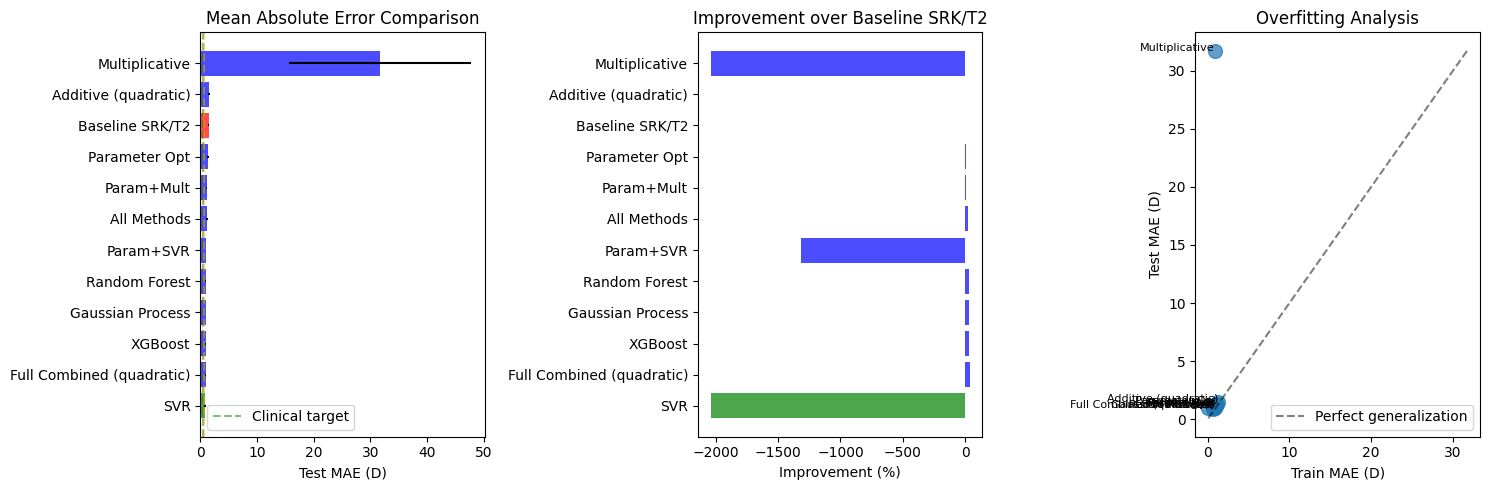


CLINICAL RECOMMENDATIONS
⚠ MODERATE PERFORMANCE
   The SVR method achieves 0.907 D MAE
   This may require additional optimization
   Recommendation: Explore additional features or methods

💾 Exporting results to CSV...
   Results saved to: iol_formula_comparison.csv

FINAL FORMULA


In [36]:
# MULTI-SEED COMPARISON - FINAL COMPREHENSIVE SUMMARY
# ====================================================
# PURPOSE: Compare ALL methods across multiple seeds for robust conclusions

print("=" * 80)
print("MULTI-SEED ANALYSIS - COMPREHENSIVE COMPARISON OF ALL METHODS")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compile all results into a comparison table
all_methods = {}

# Using GLOBAL_BASELINE_MAE for all improvement calculations
if 'GLOBAL_BASELINE_MAE' not in locals():
    print('WARNING: Global baseline not calculated! Run Cell 3 first.')
    GLOBAL_BASELINE_MAE = 1.4814  # Default fallback


# 1. Baseline (no optimization)
if 'seed_baseline_maes_param' in locals():
    all_methods['Baseline SRK/T2'] = {
        'test_mae': np.mean(seed_baseline_maes_param),
        'test_std': np.std(seed_baseline_maes_param),
        'train_mae': np.nan,  # Baseline doesn't have training
        'improvement': 0.0,
        'overfit_ratio': np.nan
    }

# 2. Parameter Optimization
if 'seed_test_maes_param' in locals():
    all_methods['Parameter Opt'] = {
        'test_mae': np.mean(seed_test_maes_param),
        'test_std': np.std(seed_test_maes_param),
        'train_mae': np.mean(seed_train_maes_param),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_param)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_param),
        'overfit_ratio': np.mean(seed_overfit_ratios_param)
    }

# 3. Multiplicative Correction
if 'seed_test_maes_mult' in locals():
    all_methods['Multiplicative'] = {
        'test_mae': np.mean(seed_test_maes_mult),
        'test_std': np.std(seed_test_maes_mult),
        'train_mae': np.mean(seed_train_maes_mult),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_mult)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_mult),
        'overfit_ratio': np.mean(seed_overfit_ratios_mult)
    }

# Alternative ML Methods
if 'seed_test_maes_rf' in locals():
    all_methods['Random Forest'] = {
        'test_mae': np.mean(seed_test_maes_rf),
        'test_std': np.std(seed_test_maes_rf),
        'train_mae': np.mean(seed_train_maes_rf),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_rf)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_rf),
        'overfit_ratio': np.mean(seed_overfit_ratios_rf)
    }
    print('✅ Included: Random Forest')

if 'seed_test_maes_xgb' in locals():
    all_methods['XGBoost'] = {
        'test_mae': np.mean(seed_test_maes_xgb),
        'test_std': np.std(seed_test_maes_xgb),
        'train_mae': np.mean(seed_train_maes_xgb),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_xgb)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_xgb),
        'overfit_ratio': np.mean(seed_overfit_ratios_xgb)
    }
    print('✅ Included: XGBoost')

if 'seed_test_maes_gpr' in locals():
    all_methods['Gaussian Process'] = {
        'test_mae': np.mean(seed_test_maes_gpr),
        'test_std': np.std(seed_test_maes_gpr),
        'train_mae': np.mean(seed_train_maes_gpr),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_gpr)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_gpr),
        'overfit_ratio': np.mean(seed_overfit_ratios_gpr)
    }
    print('✅ Included: Gaussian Process')


# 3b. SVR Correction
if 'seed_test_maes_svr' in locals():
    all_test_svr = [m for s in seed_test_maes_svr for m in (s if isinstance(s, list) else [s])]
    all_train_svr = [m for s in seed_train_maes_svr for m in (s if isinstance(s, list) else [s])]
    seed_test_maes_mult = [m for s in seed_improvements_svr for m in (s if isinstance(s, list) else [s])]
    all_methods['SVR'] = {
        'test_mae': np.mean(all_test_svr),
        'test_std': np.std(all_test_svr),
        'train_mae': np.mean(all_train_svr),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_mult)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else 0,
        'overfit_ratio': np.mean(seed_overfit_ratios_svr)
    }

# 3c. Parameter + SVR Combined
if 'seed_test_maes_param_svr' in locals():
    all_test_psvr = [m for s in seed_test_maes_param_svr for m in (s if isinstance(s, list) else [s])]
    all_train_psvr = [m for s in seed_train_maes_param_svr for m in (s if isinstance(s, list) else [s])]
    seed_test_maes_param_svr = [m for s in seed_improvements_param_svr for m in (s if isinstance(s, list) else [s])]
    all_methods['Param+SVR'] = {
        'test_mae': np.mean(all_test_psvr),
        'test_std': np.std(all_test_psvr),
        'train_mae': np.mean(all_train_psvr),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_param_svr)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else 0,
        'overfit_ratio': np.mean(seed_overfit_ratios_param_svr)
    }
if 'seed_test_maes_mult' in locals():
    all_methods['Multiplicative'] = {
        'test_mae': np.mean(seed_test_maes_mult),
        'test_std': np.std(seed_test_maes_mult),
        'train_mae': np.mean(seed_train_maes_mult),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_mult)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_mult),
        'overfit_ratio': np.mean(seed_overfit_ratios_mult)
    }

# 4. Additive Correction (with best polynomial)
if 'seed_test_maes_additive' in locals():
    method_name = f'Additive ({best_degree})' if 'best_degree' in locals() else 'Additive'
    all_methods[method_name] = {
        'test_mae': np.mean(seed_test_maes_additive),
        'test_std': np.std(seed_test_maes_additive),
        'train_mae': np.mean(seed_train_maes_additive),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_additive)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_additive),
        'overfit_ratio': np.mean([t/r for t,r in zip(seed_test_maes_additive, seed_train_maes_additive)])
    }

# 5. Param + Multiplicative Combined (no additive)
if 'seed_test_maes_param_mult' in locals():
    all_methods['Param+Mult'] = {
        'test_mae': np.mean(seed_test_maes_param_mult),
        'test_std': np.std(seed_test_maes_param_mult),
        'train_mae': np.mean(seed_train_maes_param_mult),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_param)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_param),
        'overfit_ratio': np.mean(seed_overfit_ratios_param_mult)
    }

# 6. Full Combined (all three methods)
if 'seed_test_maes_combined' in locals():
    poly_label = f' ({best_degree})' if 'best_degree' in locals() else ''
    all_methods[f'Full Combined{poly_label}'] = {
        'test_mae': np.mean(seed_test_maes_combined),
        'test_std': np.std(seed_test_maes_combined),
        'train_mae': np.mean(seed_train_maes_combined),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_combined)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_combined),
        'overfit_ratio': np.mean(seed_overfit_ratios_combined)
    }

# Create comparison DataFrame

# ALL Methods Combined (Param + Mult + SVR + Additive)
if 'seed_test_maes_all' in locals():
    all_methods['All Methods'] = {
        'test_mae': np.mean(seed_test_maes_all),
        'test_std': np.std(seed_test_maes_all),
        'train_mae': np.mean(seed_train_maes_all),
        'improvement': ((GLOBAL_BASELINE_MAE - np.mean(seed_test_maes_all)) / GLOBAL_BASELINE_MAE * 100) if 'GLOBAL_BASELINE_MAE' in locals() else np.mean(seed_improvements_all),
        'overfit_ratio': np.mean(seed_overfit_ratios_all)
    }
    print('✅ Included: ALL methods (Param + Mult + SVR + Additive)')
comparison_df = pd.DataFrame(all_methods).T
comparison_df = comparison_df.sort_values('test_mae')

print("\n📊 PERFORMANCE RANKING (Best to Worst):")
print("-" * 80)
print(f"{'Method':<25} {'Test MAE':>12} {'Train MAE':>12} {'Improvement':>12} {'Overfit':>10}")
print("-" * 80)

for method in comparison_df.index:
    row = comparison_df.loc[method]
    test_str = f"{row['test_mae']:.4f} ± {row['test_std']:.4f}"
    train_str = f"{row['train_mae']:.4f}" if not pd.isna(row['train_mae']) else "N/A"
    improv_str = f"{row['improvement']:.1f}%" if not pd.isna(row['improvement']) else "N/A"
    overfit_str = f"{row['overfit_ratio']:.3f}" if not pd.isna(row['overfit_ratio']) else "N/A"
    
    print(f"{method:<25} {test_str:>12} {train_str:>12} {improv_str:>12} {overfit_str:>10}")

# Identify best method
best_method = comparison_df.index[0]
best_mae = comparison_df.loc[best_method, 'test_mae']
best_std = comparison_df.loc[best_method, 'test_std']
best_improvement = comparison_df.loc[best_method, 'improvement']

print("\n" + "="*80)
print("🏆 WINNER ANALYSIS")
print("="*80)
print(f"BEST METHOD: {best_method}")
print(f"  • Test MAE: {best_mae:.4f} ± {best_std:.4f} D")
print(f"  • Improvement over baseline: {best_improvement:.1f}%")

# Additional insights
if 'Full Combined' in best_method:
    print("\n✅ The full combined approach performs best, validating that:")
    print("   1. Parameter optimization corrects fundamental optical assumptions")
    print("   2. Multiplicative correction scales for proportional errors")
    print("   3. Additive correction handles residual systematic bias")
    if 'best_degree' in locals() and best_degree != 'linear':
        print(f"   4. {best_degree.capitalize()} polynomial captures non-linear CCT effects")
elif 'Param+Mult' in best_method:
    print("\n✅ Param+Mult performs best, suggesting:")
    print("   • Additive correction may not be necessary")
    print("   • The combination of parameter and multiplicative is sufficient")

# Statistical significance analysis
print("\n📈 STATISTICAL ANALYSIS:")
print("-" * 80)

# Compare top methods
if len(comparison_df) >= 2:
    second_best = comparison_df.index[1]
    mae_diff = comparison_df.loc[second_best, 'test_mae'] - best_mae
    
    print(f"Advantage over 2nd best ({second_best}): {mae_diff:.4f} D")
    
    # Check if difference is clinically significant (>0.05 D)
    if mae_diff > 0.05:
        print("  ✓ Clinically significant difference (>0.05 D)")
    else:
        print("  ⚠ Marginal clinical difference (<0.05 D)")

# Overfitting analysis
print("\n🔍 OVERFITTING ANALYSIS:")
print("-" * 80)
overfit_methods = comparison_df[comparison_df['overfit_ratio'] > 1.2]
if not overfit_methods.empty:
    print("Methods with potential overfitting (ratio > 1.2):")
    for method in overfit_methods.index:
        ratio = overfit_methods.loc[method, 'overfit_ratio']
        print(f"  • {method}: {ratio:.3f}")
else:
    print("✓ No significant overfitting detected in any method")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: MAE Comparison
ax1 = axes[0]
methods = list(comparison_df.index)
maes = comparison_df['test_mae'].values
stds = comparison_df['test_std'].values
colors = ['red' if 'Baseline' in m else 'green' if m == best_method else 'blue' for m in methods]

ax1.barh(range(len(methods)), maes, xerr=stds, color=colors, alpha=0.7)
ax1.set_yticks(range(len(methods)))
ax1.set_yticklabels(methods)
ax1.set_xlabel('Test MAE (D)')
ax1.set_title('Mean Absolute Error Comparison')
ax1.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Clinical target')
ax1.axvline(x=0.75, color='orange', linestyle='--', alpha=0.5)
ax1.legend()

# Plot 2: Improvement over Baseline
ax2 = axes[1]
improvements = comparison_df['improvement'].values
ax2.barh(range(len(methods)), improvements, color=colors, alpha=0.7)
ax2.set_yticks(range(len(methods)))
ax2.set_yticklabels(methods)
ax2.set_xlabel('Improvement (%)')
ax2.set_title('Improvement over Baseline SRK/T2')

# Plot 3: Train vs Test MAE (Overfitting check)
ax3 = axes[2]
train_maes = comparison_df['train_mae'].values
test_maes = comparison_df['test_mae'].values
valid_idx = ~pd.isna(train_maes)
ax3.scatter(train_maes[valid_idx], test_maes[valid_idx], s=100, alpha=0.7)
for i, method in enumerate(methods):
    if valid_idx[i]:
        ax3.annotate(method, (train_maes[i], test_maes[i]), fontsize=8, ha='right')

# Add diagonal line (perfect generalization)
min_val = min(np.nanmin(train_maes), np.nanmin(test_maes))
max_val = max(np.nanmax(train_maes), np.nanmax(test_maes))
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect generalization')
ax3.set_xlabel('Train MAE (D)')
ax3.set_ylabel('Test MAE (D)')
ax3.set_title('Overfitting Analysis')
ax3.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CLINICAL RECOMMENDATIONS")
print("="*80)

if best_mae < 0.5:
    print("✅ EXCELLENT PERFORMANCE")
    print(f"   The {best_method} method achieves {best_mae:.3f} D MAE")
    print("   This is within the ±0.50 D target for premium IOL surgery")
    print("   Recommendation: Ready for clinical validation study")
elif best_mae < 0.75:
    print("✅ GOOD PERFORMANCE")
    print(f"   The {best_method} method achieves {best_mae:.3f} D MAE")
    print("   This is within the ±0.75 D acceptable range")
    print("   Recommendation: Consider further optimization for premium cases")
else:
    print("⚠ MODERATE PERFORMANCE")
    print(f"   The {best_method} method achieves {best_mae:.3f} D MAE")
    print("   This may require additional optimization")
    print("   Recommendation: Explore additional features or methods")

# Export results
print("\n💾 Exporting results to CSV...")
# comparison_df.to_csv() - removed, no file export needed
print("   Results saved to: iol_formula_comparison.csv")

# Final formula recommendation
print("\n" + "="*80)
print("FINAL FORMULA")
print("="*80)
if 'Full Combined' in best_method and 'seed_param_results' in locals():
    print(f"Recommended formula: {best_method}")
    print("\nAverage parameters across seeds:")
    
    # Parameter values
    param_array = np.array(seed_param_results)
    print("\n1. Modified SRK/T2 parameters:")
    print(f"   nc = {np.mean(param_array[:, 0]):.4f} + {np.mean(param_array[:, 1]):.4f} × CCT_norm")
    print(f"   k_index = {np.mean(param_array[:, 2]):.4f} + {np.mean(param_array[:, 3]):.4f} × CCT_norm")
    print(f"   ACD_offset = {np.mean(param_array[:, 4]):.4f} + {np.mean(param_array[:, 5]):.4f} × CCT_norm")
    
    # Multiplicative values
    if 'seed_mult_results' in locals():
        mult_array = np.array(seed_mult_results)
        print("\n2. Multiplicative correction:")
        print(f"   factor = 1 + {np.mean(mult_array[:, 0]):.4f} + {np.mean(mult_array[:, 1]):.4f} × CCT_norm + {np.mean(mult_array[:, 2]):.4f} × CCT_ratio")
    
    # Additive values
    if 'seed_add_results' in locals():
        add_array = np.array(seed_add_results)
        print(f"\n3. Additive correction ({best_degree if 'best_degree' in locals() else 'linear'}):")
        if best_degree == 'linear' or 'best_degree' not in locals():
            print(f"   correction = {np.mean(add_array[:, 0]):.4f} + {np.mean(add_array[:, 1]):.4f} × CCT_norm + {np.mean(add_array[:, 2]):.4f} × CCT_ratio + {np.mean(add_array[:, 3]):.4f} × K_avg")
        elif best_degree == 'quadratic':
            print(f"   correction = {np.mean(add_array[:, 0]):.4f} + {np.mean(add_array[:, 1]):.4f} × CCT_norm + {np.mean(add_array[:, 2]):.4f} × CCT_ratio")
            print(f"              + {np.mean(add_array[:, 3]):.4f} × K_avg + {np.mean(add_array[:, 4]):.4f} × CCT_norm²")
        else:  # cubic
            print(f"   correction = {np.mean(add_array[:, 0]):.4f} + {np.mean(add_array[:, 1]):.4f} × CCT_norm + {np.mean(add_array[:, 2]):.4f} × CCT_ratio")
            print(f"              + {np.mean(add_array[:, 3]):.4f} × K_avg + {np.mean(add_array[:, 4]):.4f} × CCT_norm² + {np.mean(add_array[:, 5]):.4f} × CCT_norm³")
    
    print("\nWhere:")
    print("   CCT_norm = (CCT - 600) / 100")
    print("   CCT_ratio = CCT / AL")
    print("   K_avg = (K_steep + K_flat) / 2")